In [1]:
import pandas as pd

# Load the dataset
file_path = 'combined_articles.csv'
data = pd.read_csv(file_path)

# Convert the Timestamp column to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Sort the data by Article ID and Timestamp
data = data.sort_values(by=['Article ID', 'Timestamp'])

# Initialize a dictionary to store edges and weights
edges = {}

base_time = 0
base_revision_times = []
prev_row = None

for index, row in data.iterrows():
    if prev_row is not None:
        time_diff = (row['Timestamp'] - prev_row['Timestamp']).total_seconds()
        base_revision_times.append(time_diff)
    if len(base_revision_times) > 0:
        base_time = sum(base_revision_times) / len(base_revision_times)
    
    prev_row = row

# Define a time limit for considering revisions as disagreements (in seconds)
time_limit = base_time  # 1 hour

# Iterate through the articles
for article_id, article_data in data.groupby('Article ID'):
    # Initialize the previous row
    prev_row = None
    
    # Iterate through the revisions of the article
    for index, row in article_data.iterrows():
        # If there is a previous row
        if prev_row is not None:
            # Check if the current user is different from the previous user
            if row['User/IP'] != prev_row['User/IP']:
                # Calculate the time difference in seconds
                time_diff = (row['Timestamp'] - prev_row['Timestamp']).total_seconds()
                
                # Calculate the weight based on the time difference
                weight = max(0, -time_diff / time_limit + 1)
                
                # Create an edge tuple
                edge = (prev_row['User/IP'], row['User/IP'])
                
                # Add or update the edge in the dictionary
                if edge in edges:
                    edges[edge] += weight
                else:
                    edges[edge] = weight
        
        # Update the previous row
        prev_row = row

# Initialize a dictionary to store total weights by article
total_weights_by_article = {}

# Iterate through the articles again to calculate total weights
for article_id, article_data in data.groupby('Article ID'):
    total_weight = 0
    prev_row = None

    revision_times = []
    time_limit = 3600
    #calculate average time between revisions
    for index, row in article_data.iterrows():
        if prev_row is not None:
            time_diff = (row['Timestamp'] - prev_row['Timestamp']).total_seconds()
            revision_times.append(time_diff)
        prev_row = row
    if len(revision_times) > 0:
        time_limit = sum(revision_times) / len(revision_times)
    
    for index, row in article_data.iterrows():
        if prev_row is not None and row['User/IP'] != prev_row['User/IP']:
            time_diff = (row['Timestamp'] - prev_row['Timestamp']).total_seconds()
            weight = max(0, -time_diff / time_limit + 1)
            total_weight += weight
        
        prev_row = row
    
    total_weights_by_article[article_id] = total_weight

# Convert the dictionary to a DataFrame for better readability
total_weights_df = pd.DataFrame(list(total_weights_by_article.items()), columns=['Article ID', 'Total Weight'])

# Display the DataFrame
total_weights_df.head()

#add article title to total_weights_df
article_titles = data[['Article ID', 'Article Title']].drop_duplicates()
total_weights_df = total_weights_df.merge(article_titles, on='Article ID')



In [2]:
total_weights_df

,Article ID,Total Weight,Article Title
0,277170,2909.209222,Maumoon Abdul Gayoom
1,1700650,351.927614,Ahmed Shafeeq Ibrahim Moosa
2,1711049,0.000000,Mohamed Ameen
3,2375585,3037.358886,Mohamed Nasheed
4,4430956,158.037064,Mohamed Munavvar
5,4466814,225.870077,Hassan Saeed
6,4478561,74.144302,Mohamed Zahir Hussain
7,9362881,1577.365490,Mohammed Waheed Hassan
8,9466160,699.214027,Qasim Ibrahim
9,12018262,2.000000,Mohamed Saeed


In [3]:
# top 10 articles with the highest total weights
top_10_articles = total_weights_df.sort_values(by='Total Weight', ascending=False).head(10)
top_10_articles

,Article ID,Total Weight,Article Title
3,2375585,3037.358886,Mohamed Nasheed
0,277170,2909.209222,Maumoon Abdul Gayoom
14,41119270,1664.308922,Abdulla Yameen
7,9362881,1577.365490,Mohammed Waheed Hassan
23,72808021,915.857735,Mohamed Muizzu
8,9466160,699.214027,Qasim Ibrahim
1,1700650,351.927614,Ahmed Shafeeq Ibrahim Moosa
16,47141193,313.144871,Ahmed Adeeb
5,4466814,225.870077,Hassan Saeed
12,37151585,203.231825,Abdulla Shahid


In [4]:
#calculate average total weight for the entire dataset
total_weights_df['Total Weight'].mean()


331.55101661615765

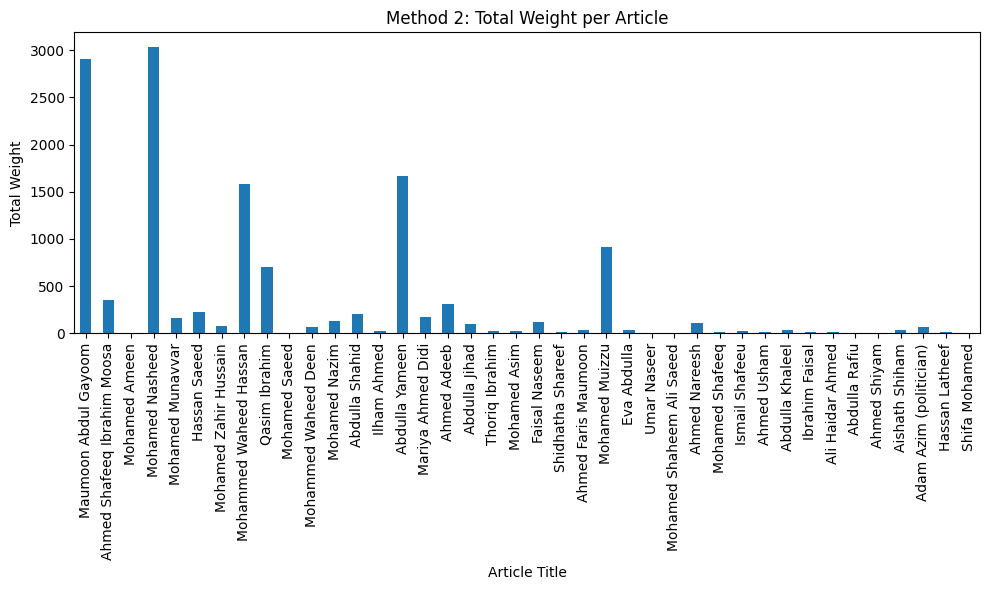

In [5]:
import matplotlib.pyplot as plt

# Assuming total_weights_df is a DataFrame with 'Article Title' and 'Total Weight' as its columns
plt.figure(figsize=(10,6))
total_weights_df.set_index('Article Title')['Total Weight'].plot(kind='bar')
plt.title('Method 2: Total Weight per Article')
plt.xlabel('Article Title')
plt.ylabel('Total Weight')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for better visibility
plt.show()

# by time


In [6]:
import pandas as pd

# Load the dataset
file_path = 'combined_articles.csv'
data = pd.read_csv(file_path)

# Convert the Timestamp column to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Extract month from Timestamp
data['Month'] = data['Timestamp'].dt.to_period('M')


/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52150/901863741.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['Month'] = data['Timestamp'].dt.to_period('M')


In [7]:
data

,Article Title,Article ID,User/IP,Timestamp,Revised Text,Month
0,Abdulla Shahid,37151585,Ushau97,2012-09-28 11:27:54+00:00,{{Infobox Officeholder\n|name =Abdulla...,2012-09
1,Abdulla Shahid,37151585,Danrok,2012-09-28 11:54:00+00:00,{{Prod blp/dated|concern=All biographies of li...,2012-09
2,Abdulla Shahid,37151585,Ushau97,2012-09-28 17:19:24+00:00,{{Infobox Officeholder\n|name =Abdulla...,2012-09
3,Abdulla Shahid,37151585,Ushau97,2012-09-29 10:41:23+00:00,{{Infobox Officeholder\n|name =Abdulla...,2012-09
4,Abdulla Shahid,37151585,Ushau97,2012-09-29 12:04:16+00:00,{{Infobox Officeholder\n|name =Abdulla...,2012-09
...,...,...,...,...,...,...
9397,Abdulla Rafiu,75371185,Youknowwhoistheman,2023-11-21 13:01:51+00:00,'''Abdulla Rafiu''' is a [[Maldives|Maldivian]...,2023-11
9398,Abdulla Rafiu,75371185,Familcom,2023-11-21 15:22:30+00:00,[[File:Abdulla_Rafiu_portrait.jpg|thumb|right]...,2023-11
9399,Abdulla Rafiu,75371185,JTtheOG,2023-11-21 17:45:49+00:00,[[File:Abdulla_Rafiu_portrait.jpg|thumb|right]...,2023-11
9400,Abdulla Rafiu,75371185,DarkNight0917,2023-12-18 06:01:38+00:00,{{Short description|Maldivian politician}}\n[[...,2023-12


In [8]:


weights_list = []


# Iterate through the articles
for article_id, article_data in data.groupby(['Article ID', 'Month']):
    prev_row = None
    time_limit = base_time
    revision_times = []

    for index, row in article_data.iterrows():
        if prev_row is not None:
            time_diff = (row['Timestamp'] - prev_row['Timestamp']).total_seconds()
            revision_times.append(time_diff)
        prev_row = row
    if len(revision_times) > 0:
        time_limit = sum(revision_times) / len(revision_times)

    for index, row in article_data.iterrows():
        if prev_row is not None and row['User/IP'] != prev_row['User/IP']:
            time_diff = (row['Timestamp'] - prev_row['Timestamp']).total_seconds()
            weight = max(0, -time_diff / time_limit + 1)
            
            # Append the result to the list
            weights_list.append({'Article ID': article_id, 'Month': row['Month'], 'Weight': weight})
        
        prev_row = row


In [9]:
# Convert the list to a DataFrame
weights_df = pd.DataFrame(weights_list)
# # #seperate article id and month
weights_df[['Article ID', 'Month']] = weights_df['Article ID'].apply(pd.Series)


# Group by Article ID and Month and sum the weights
weights_df = weights_df.groupby(['Article ID', 'Month']).sum().reset_index()


# # #add article title to total_weights_by_month_df
Article_titles = data[['Article ID', 'Article Title']].drop_duplicates()
weights_df = weights_df.merge(article_titles, on='Article ID')

weights_df

,Article ID,Month,Weight,Article Title
0,277170,2003-07,9.801719,Maumoon Abdul Gayoom
1,277170,2004-03,6.312925,Maumoon Abdul Gayoom
2,277170,2004-06,4.756526,Maumoon Abdul Gayoom
3,277170,2004-07,8.878091,Maumoon Abdul Gayoom
4,277170,2004-08,2.000000,Maumoon Abdul Gayoom
...,...,...,...,...
823,75386087,2023-12,6.989034,Aishath Shiham
824,75458132,2023-12,8.197473,Adam Azim (politician)
825,75458132,2024-01,53.293659,Adam Azim (politician)
826,75458538,2023-12,12.490506,Hassan Latheef


In [10]:
unique_articles = weights_df['Article Title'].unique()


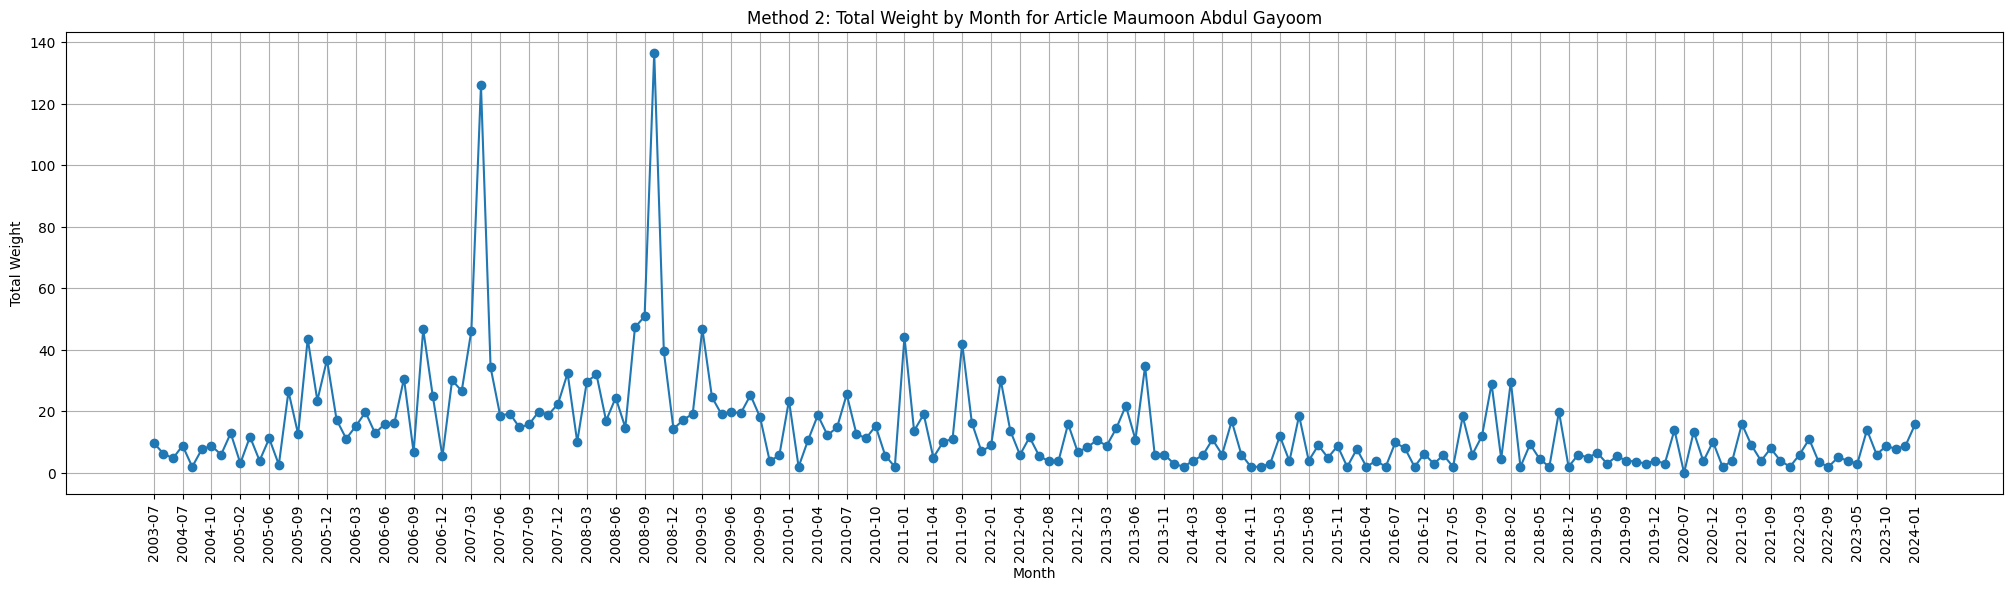

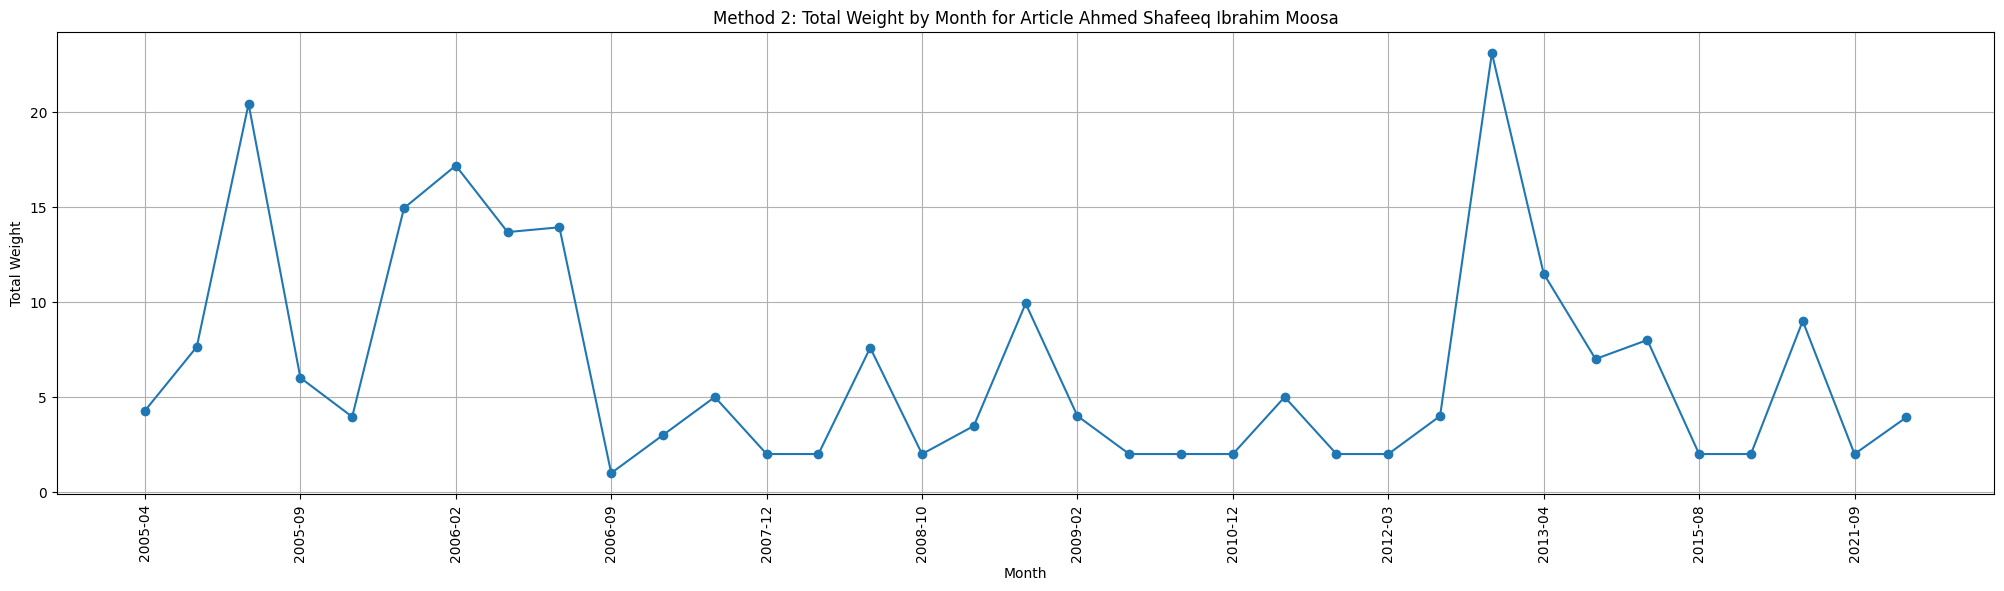

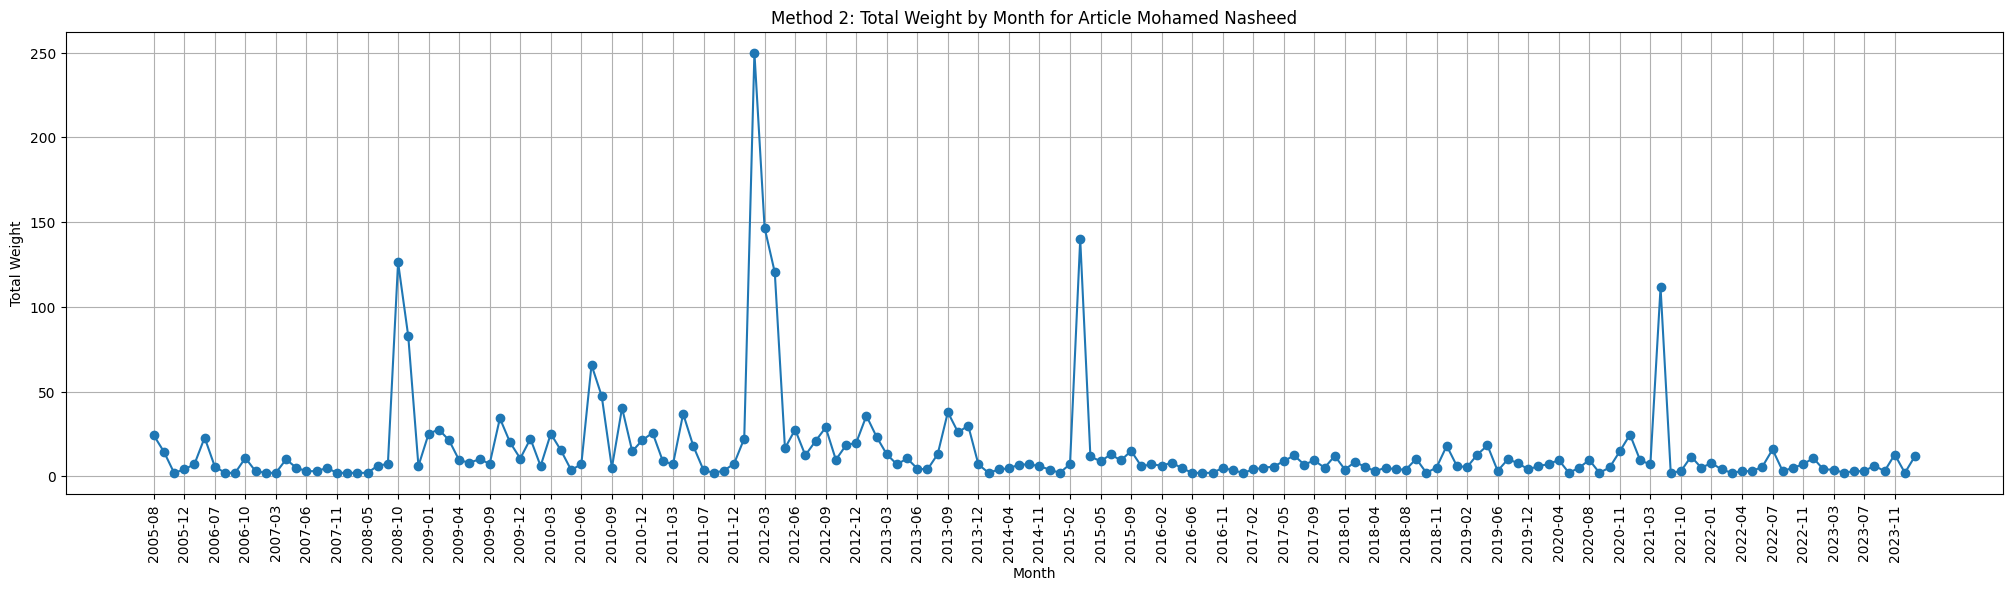

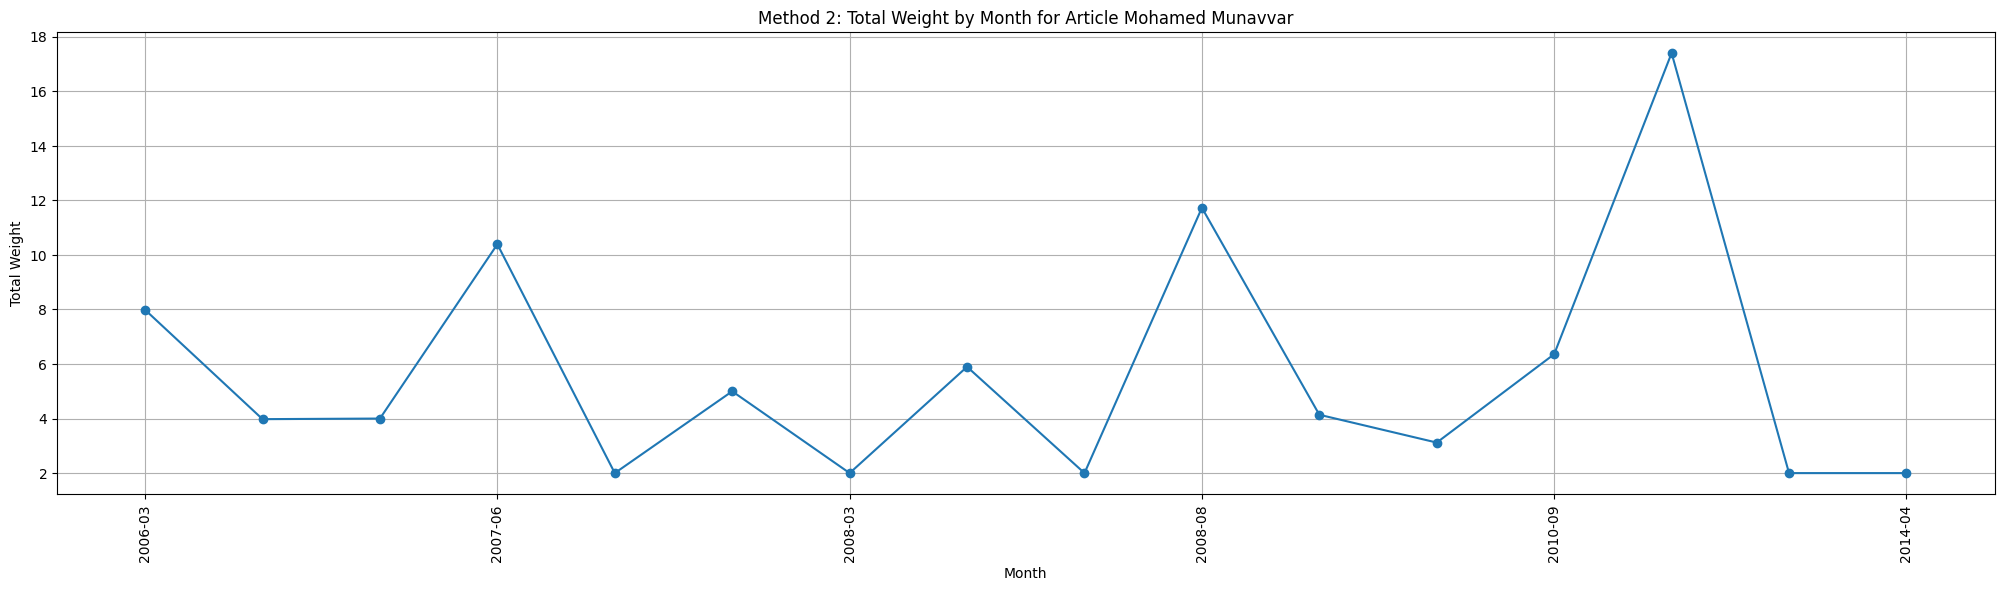

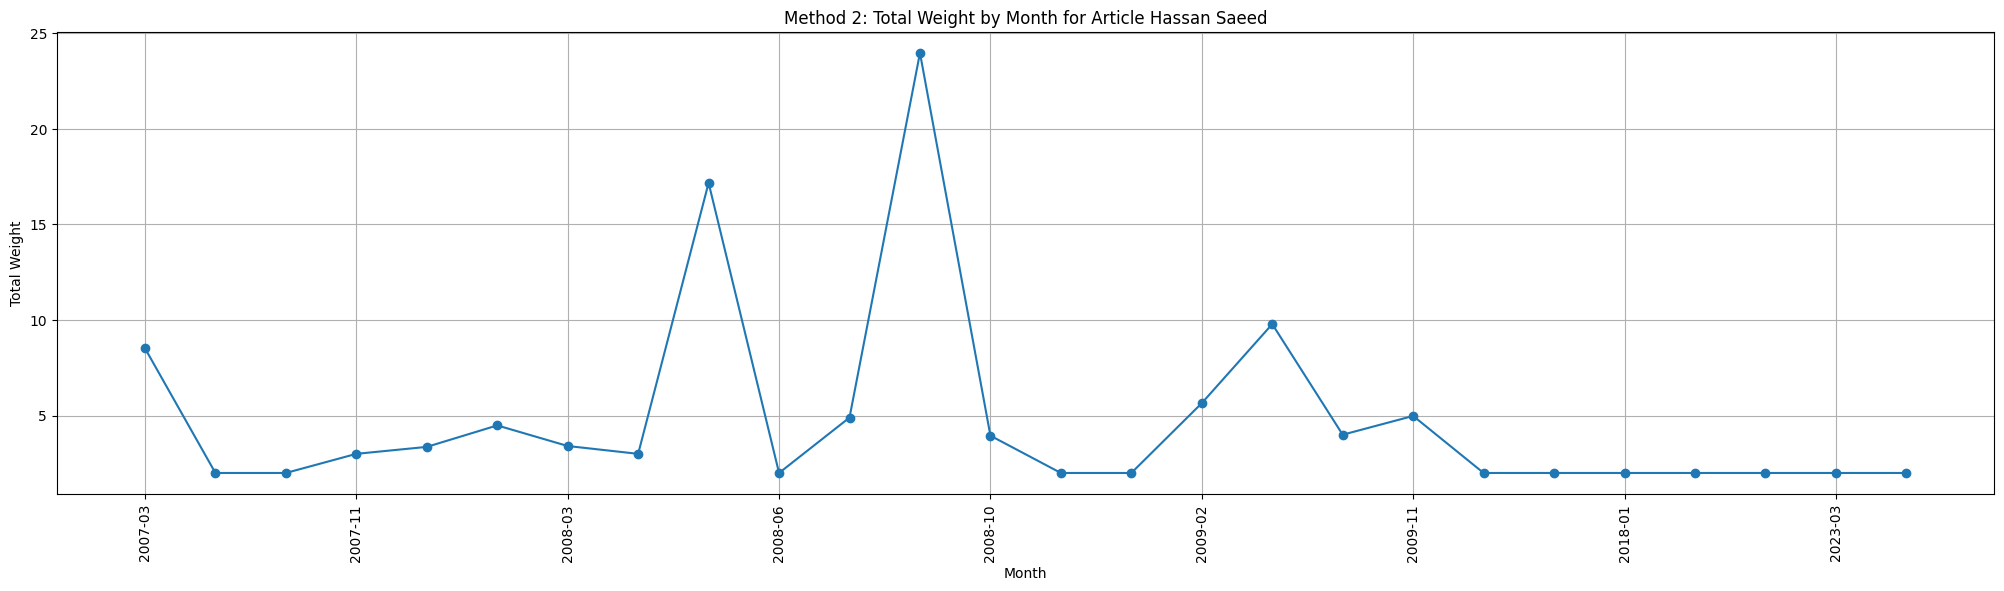

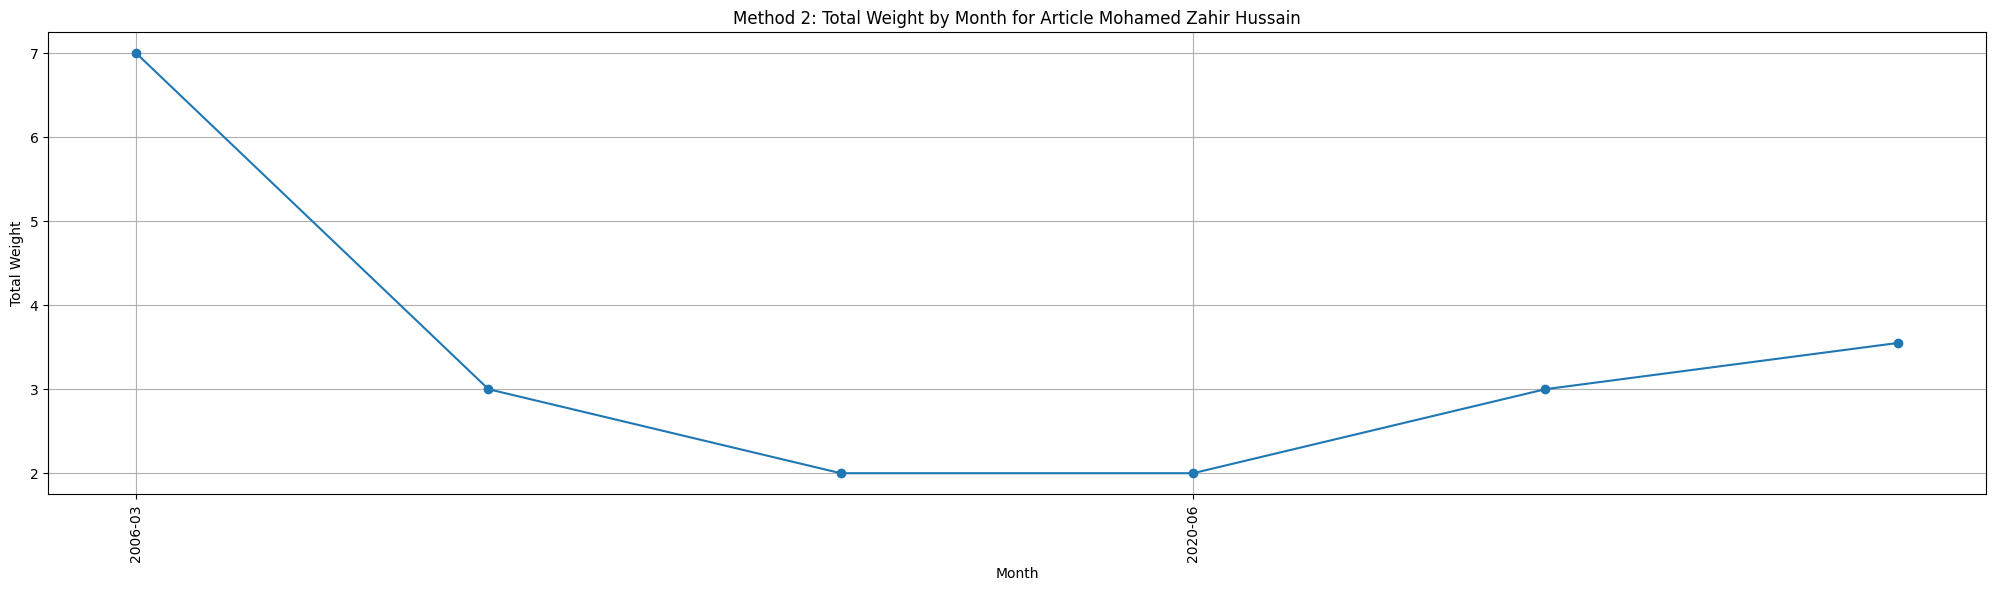

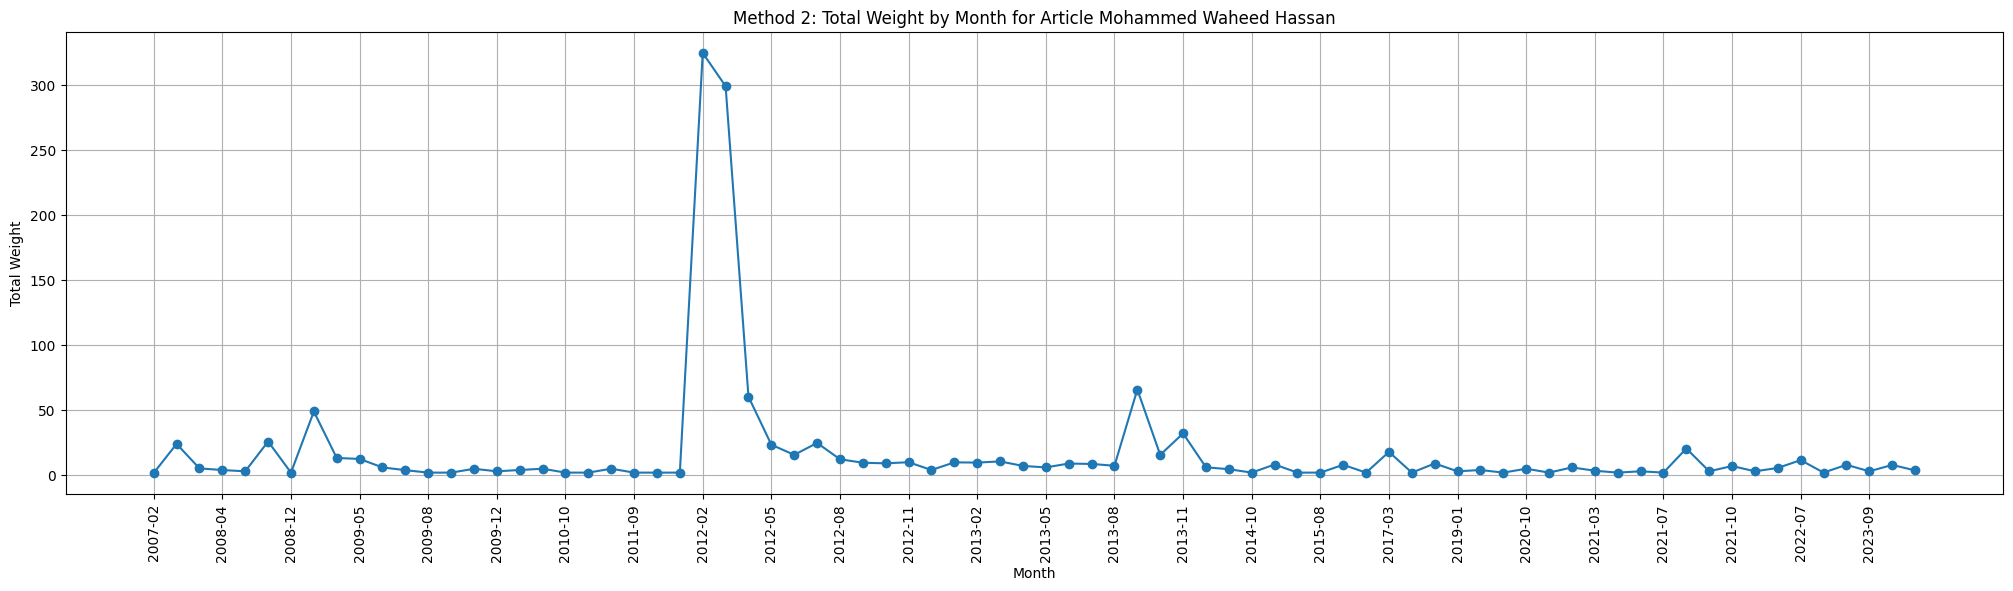

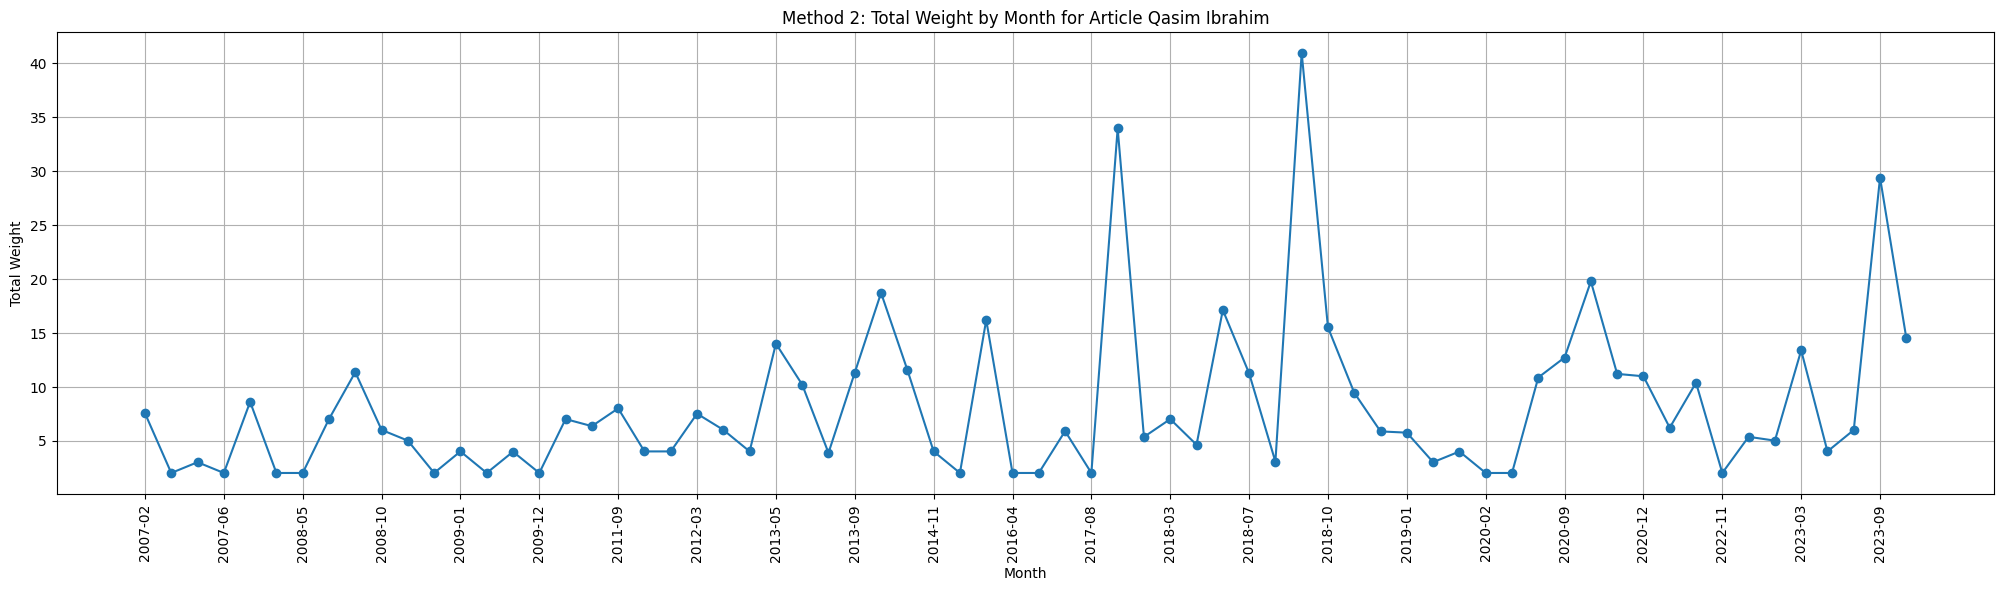

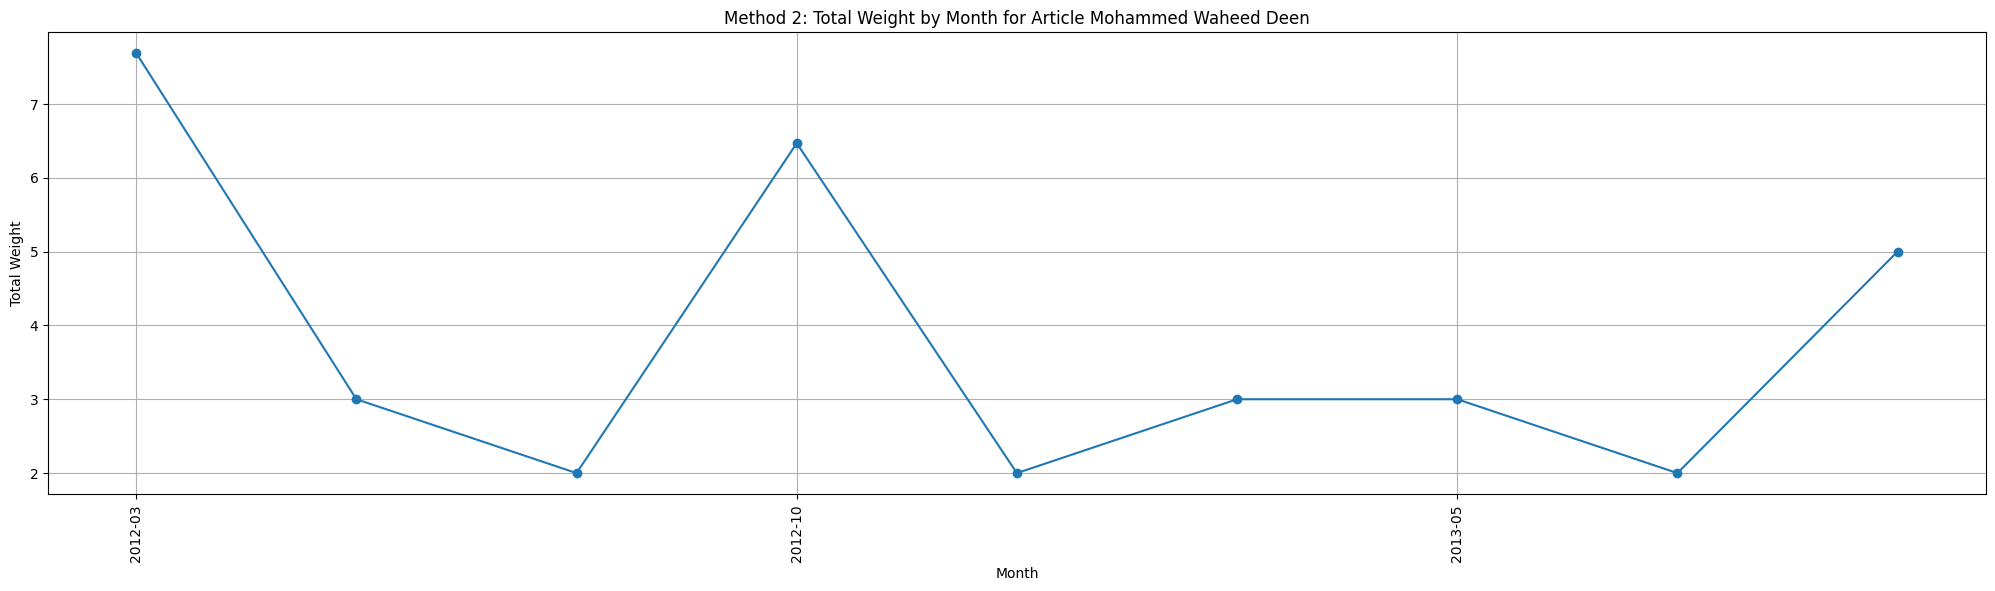

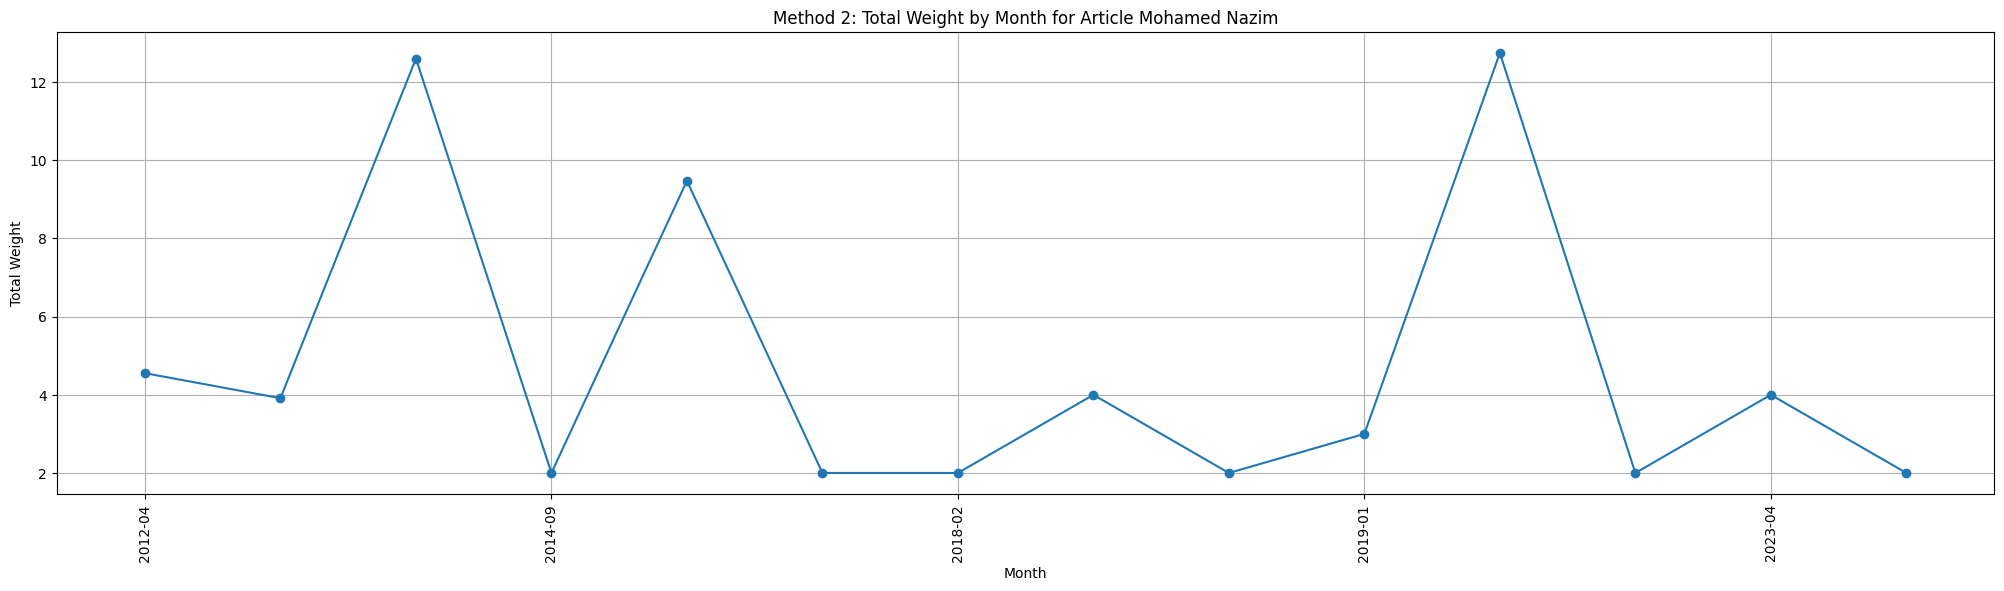

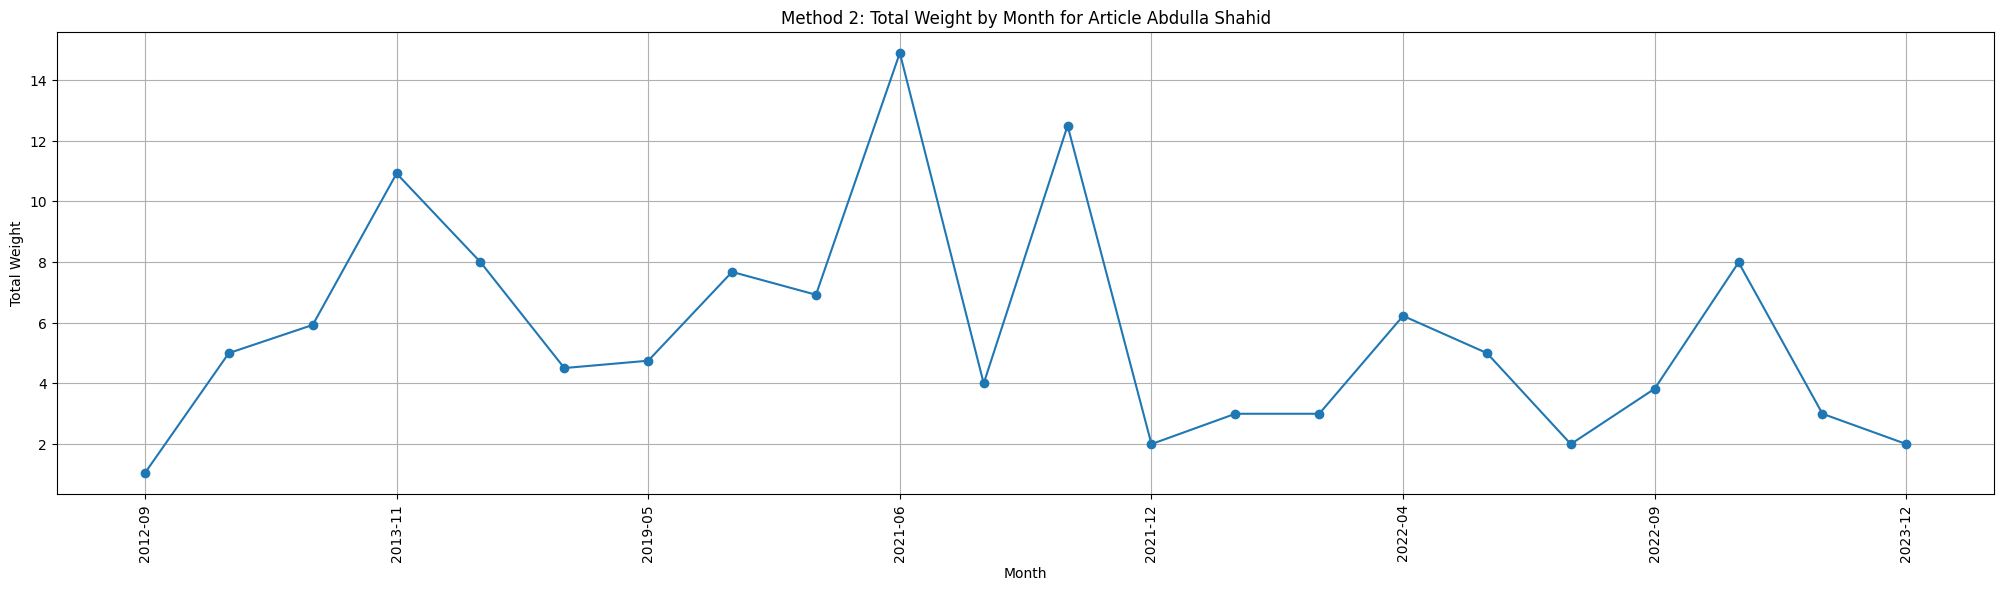

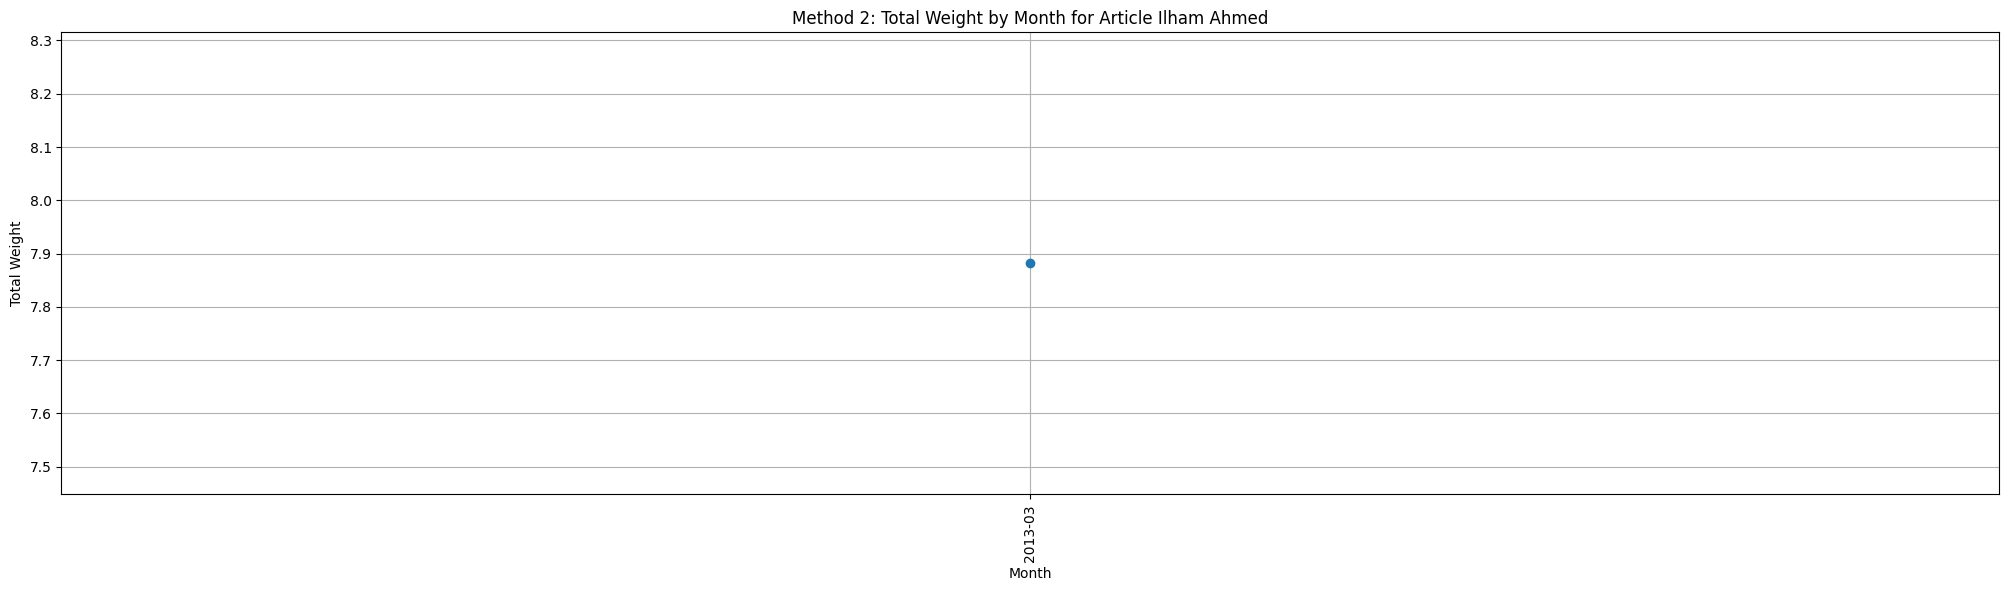

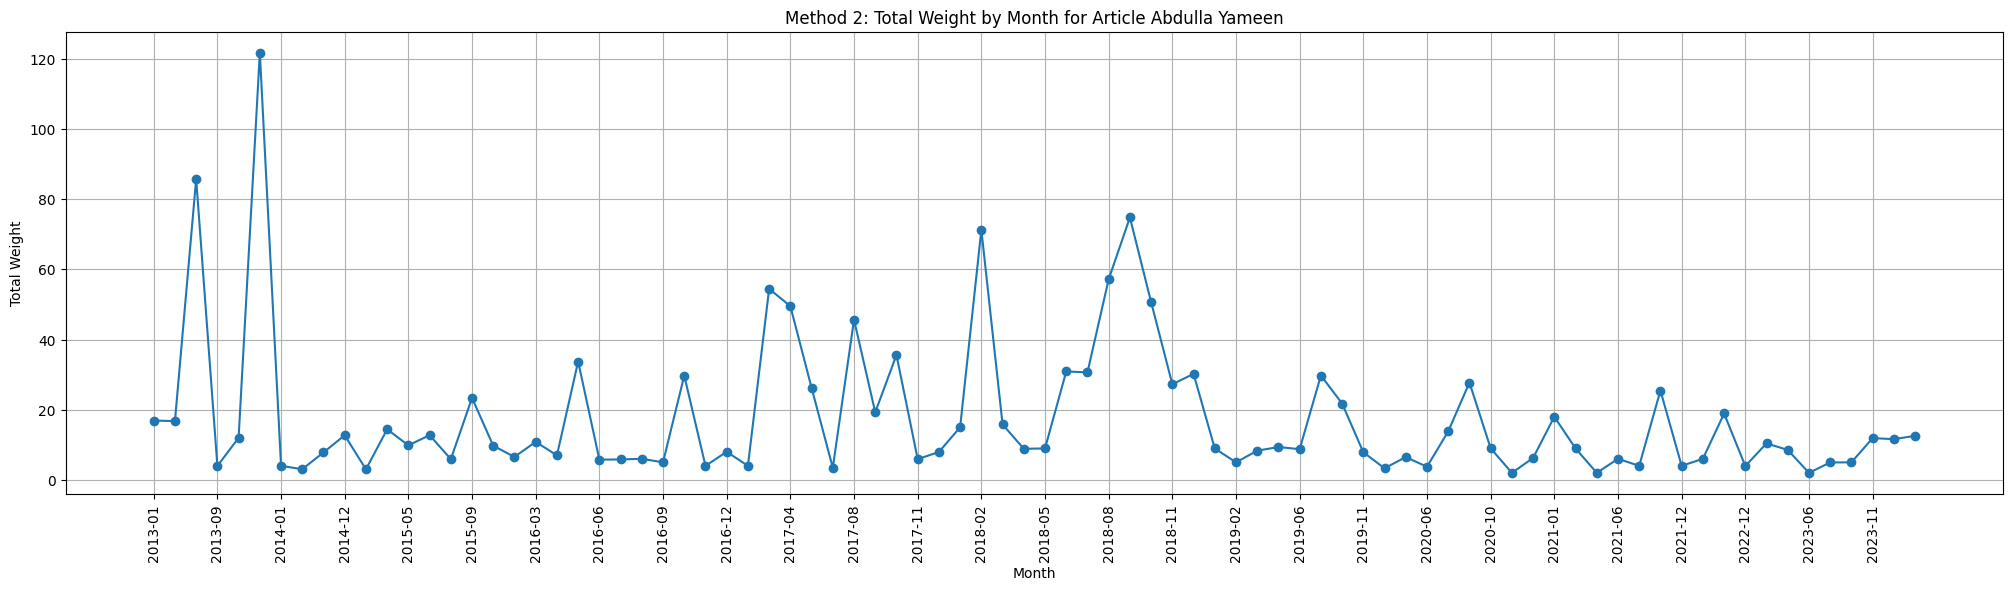

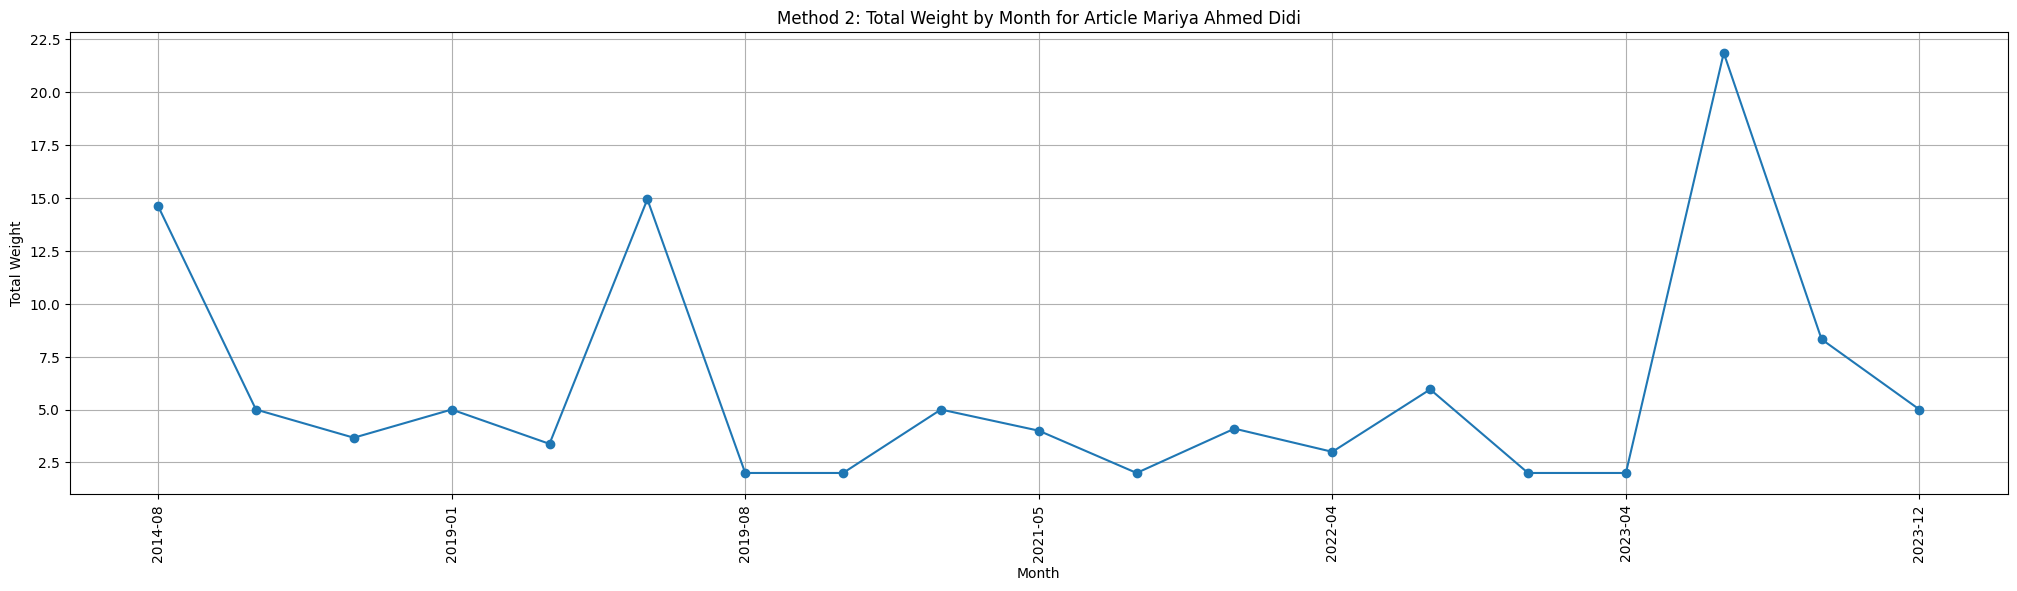

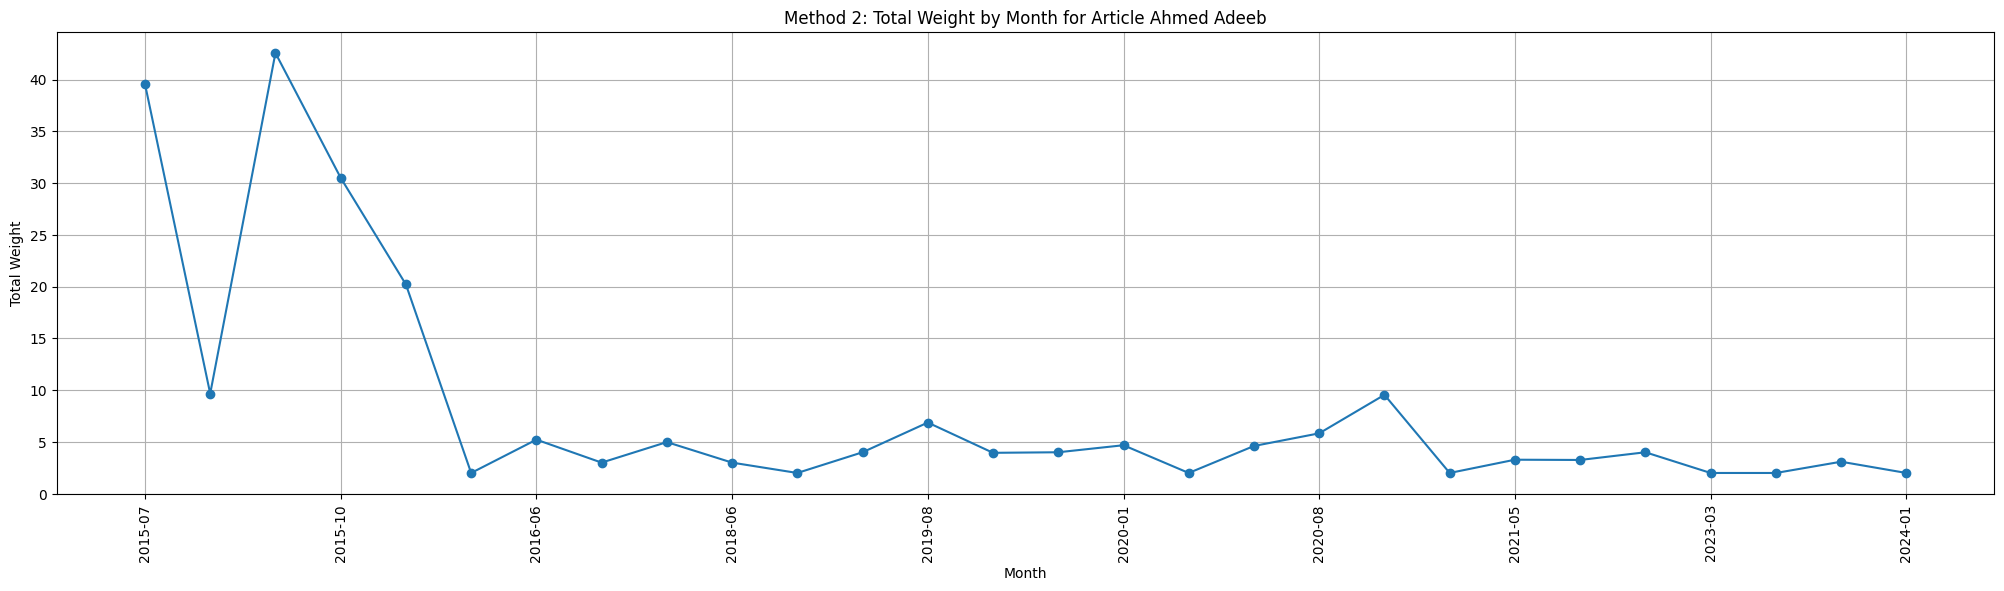

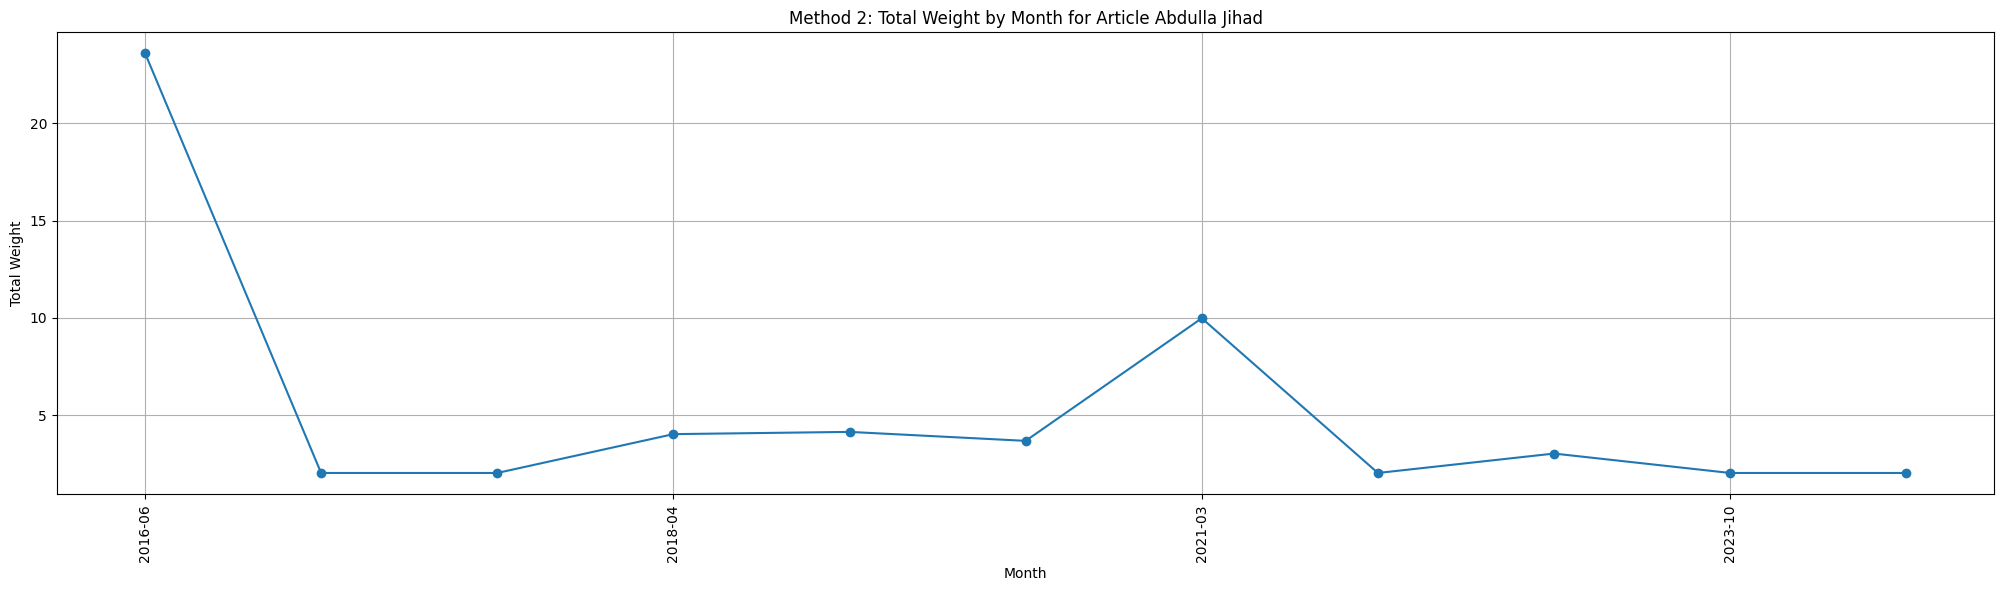

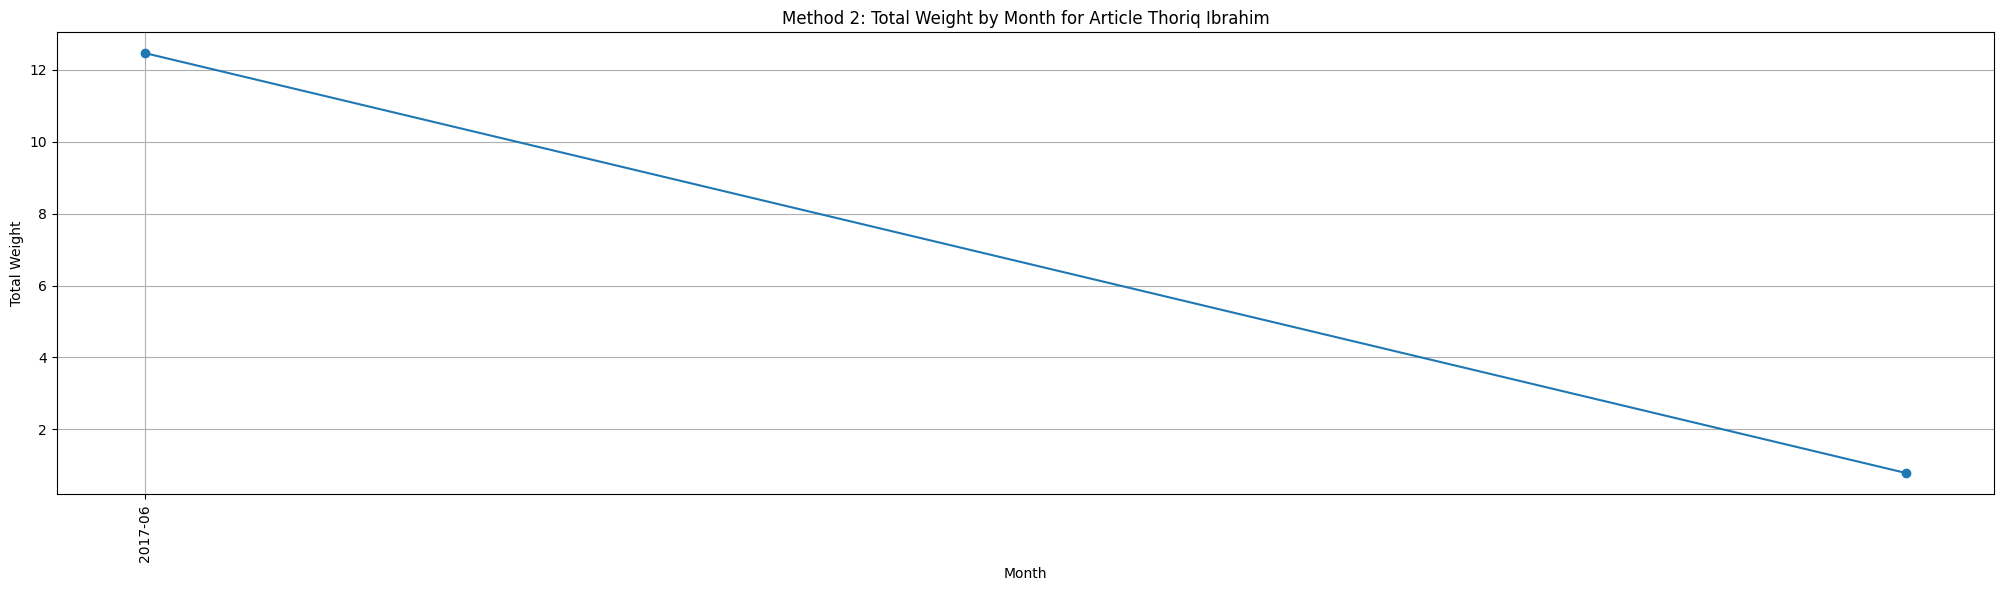

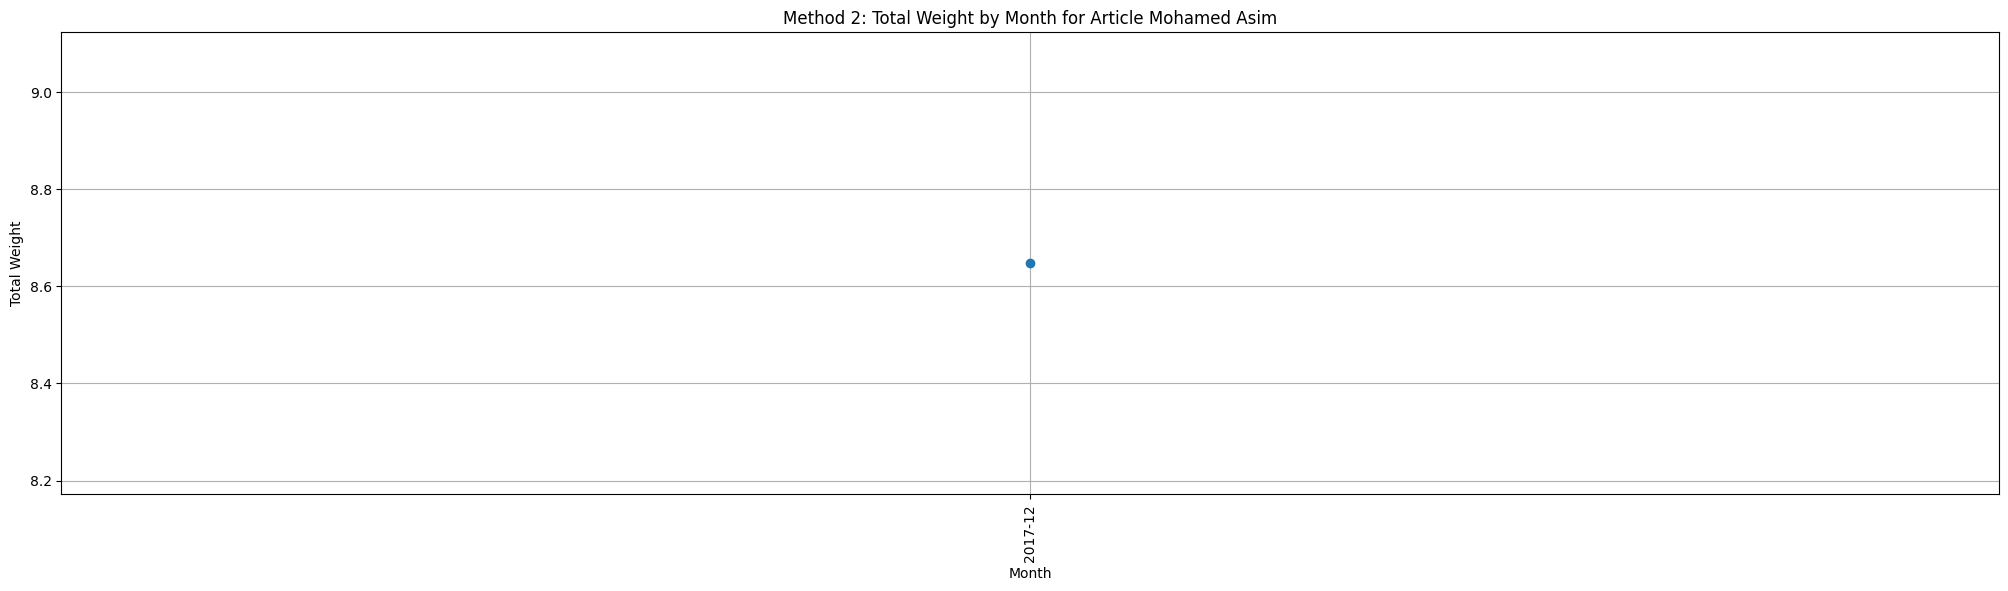

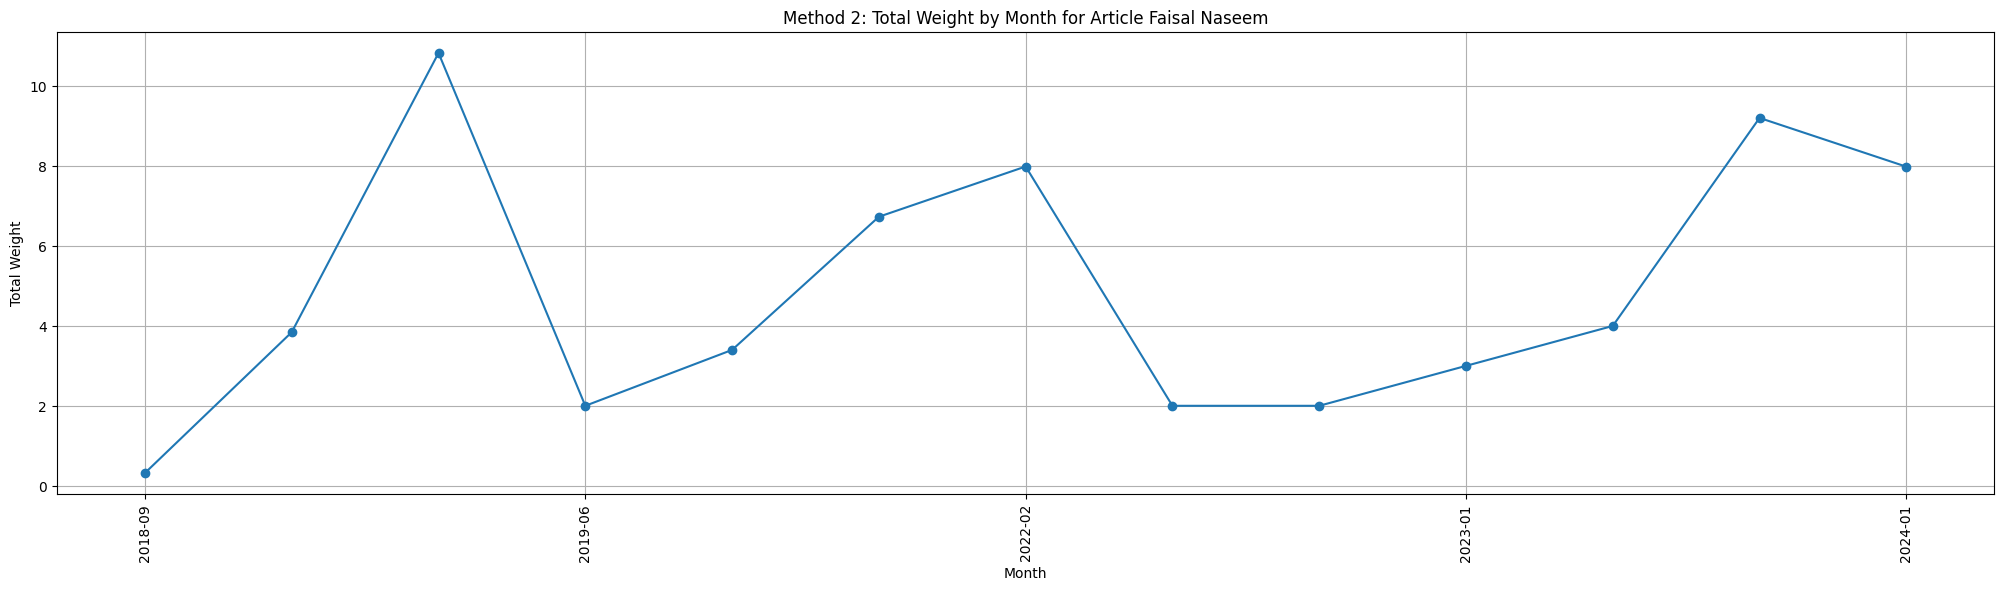

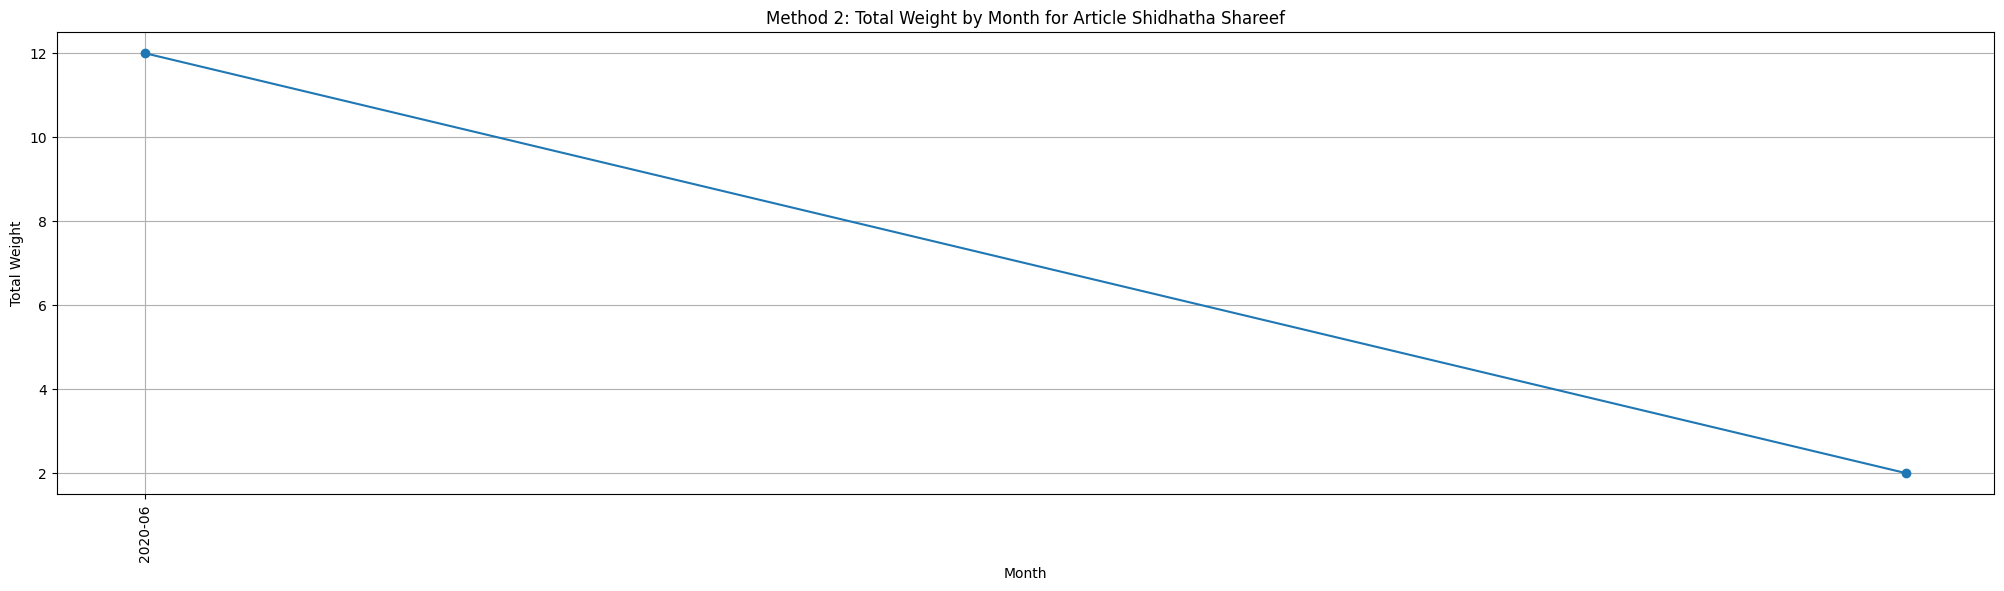

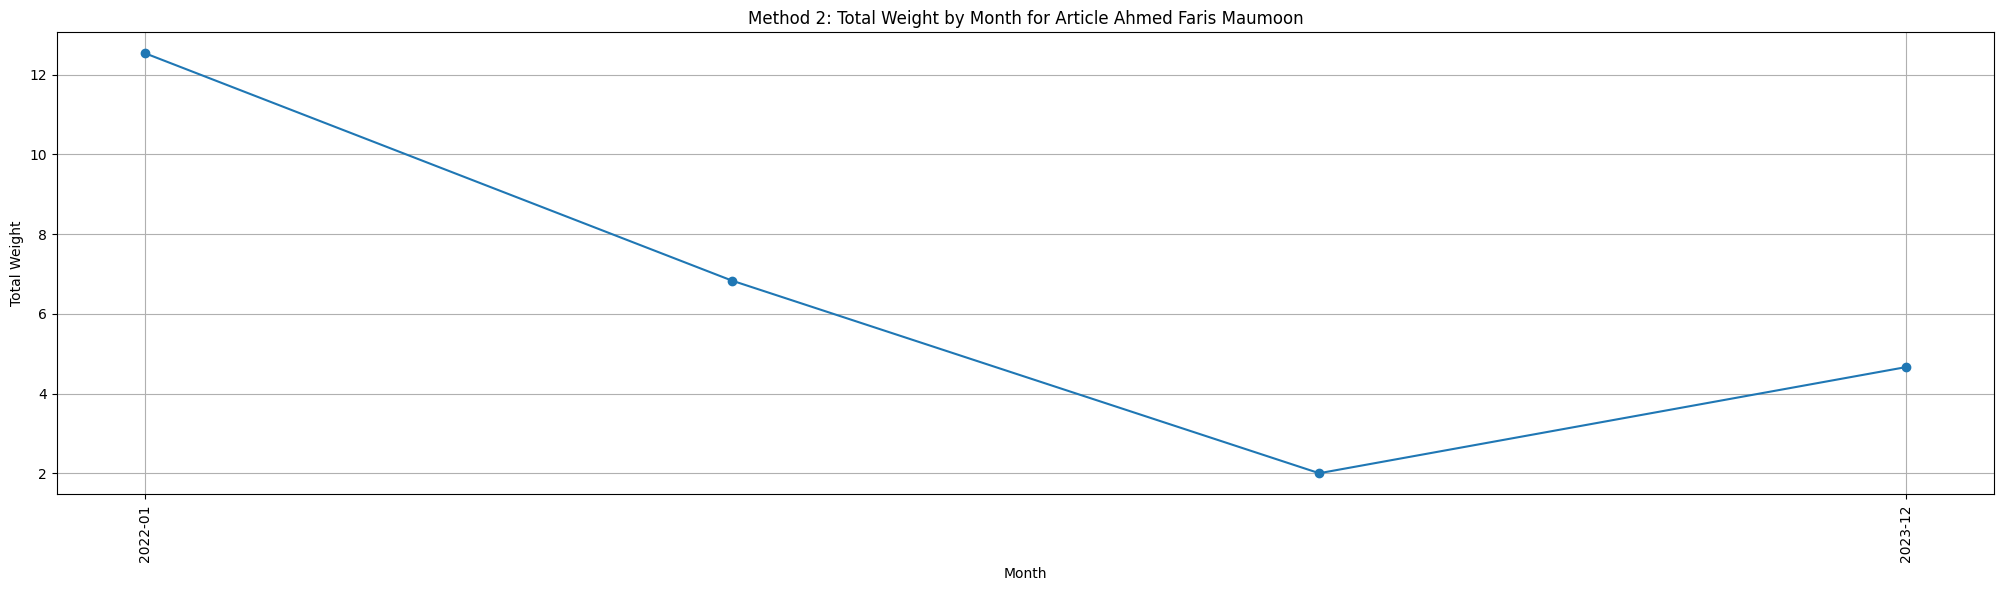

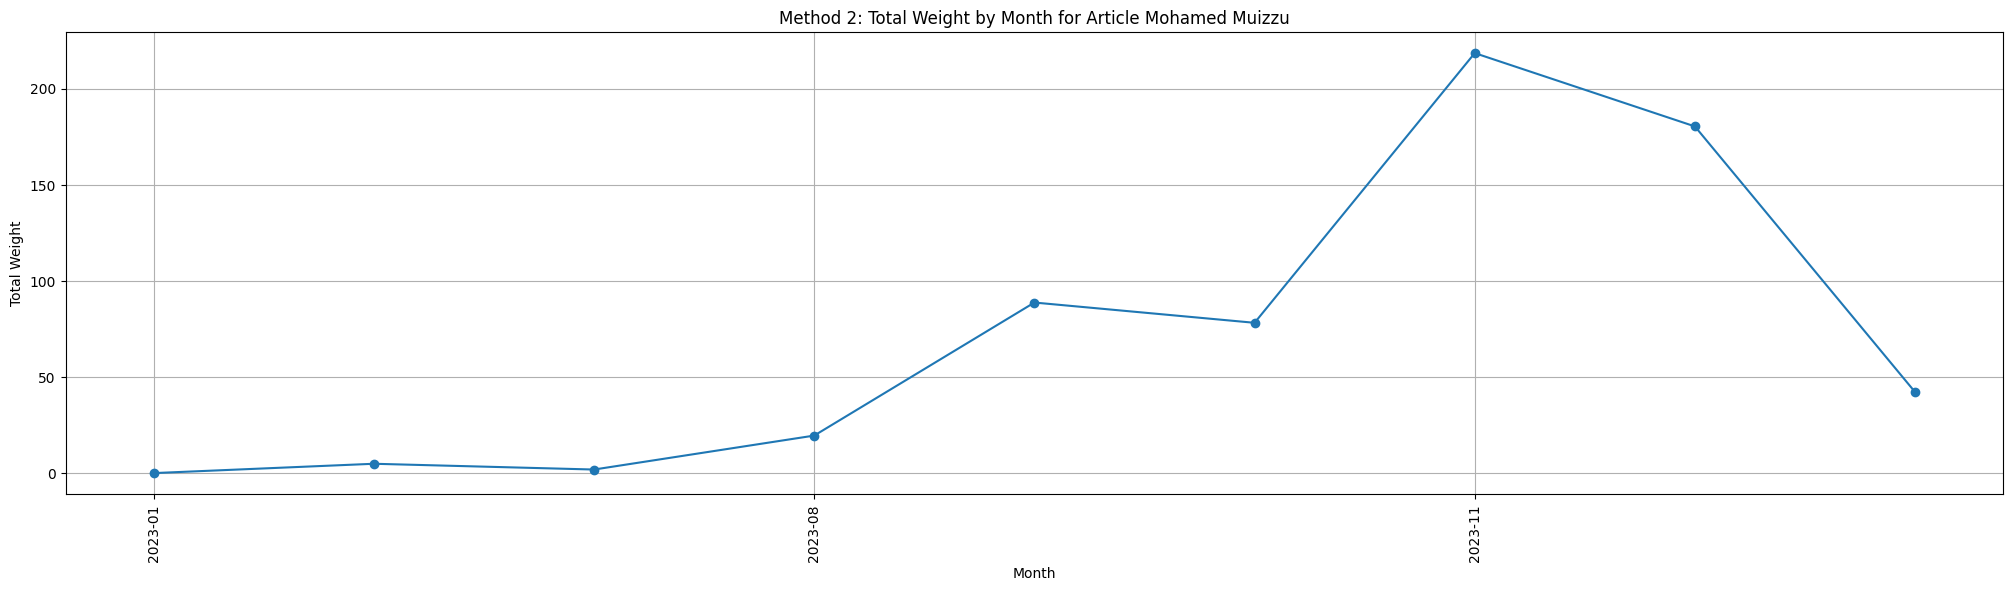

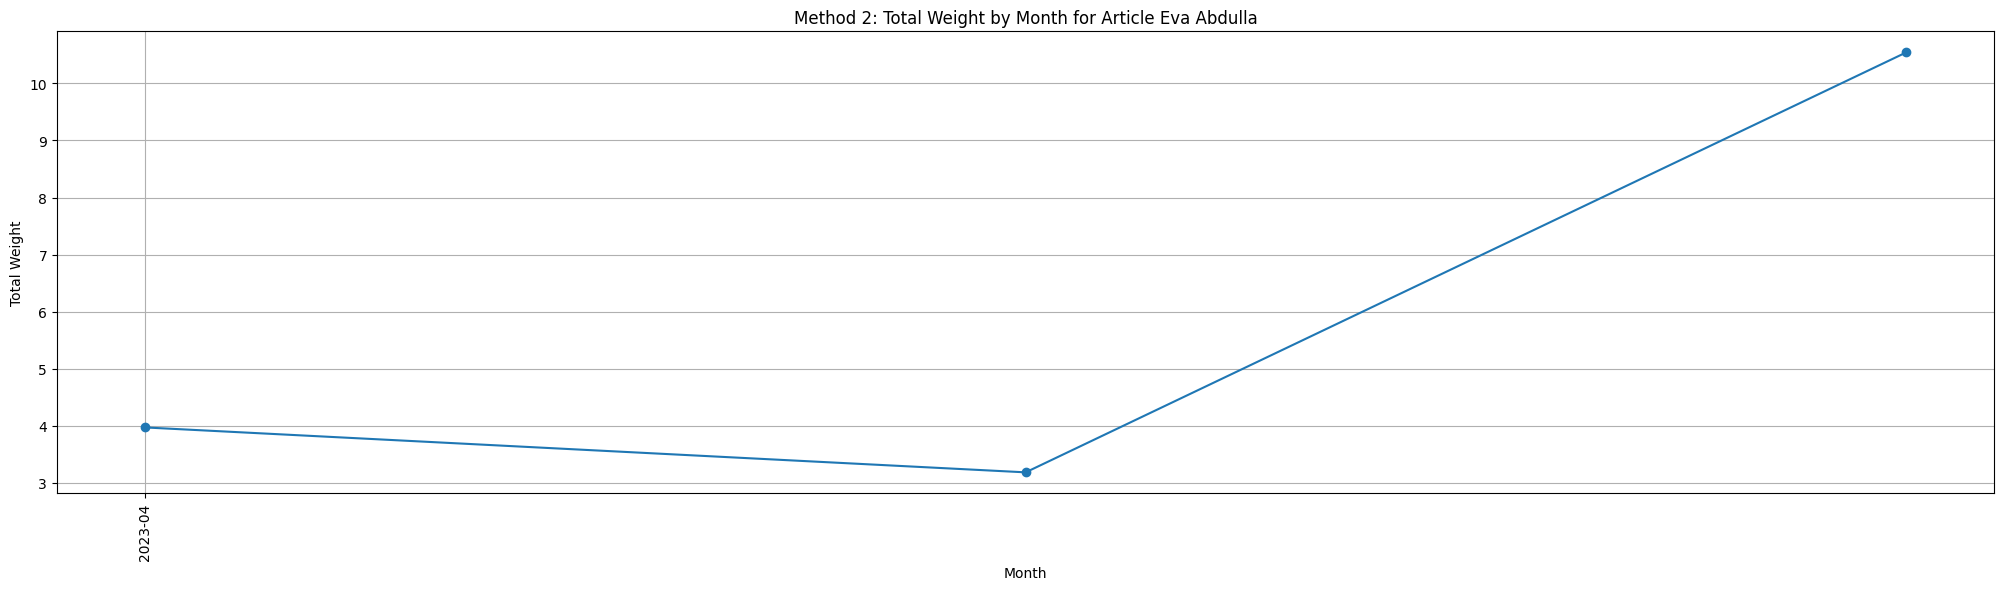

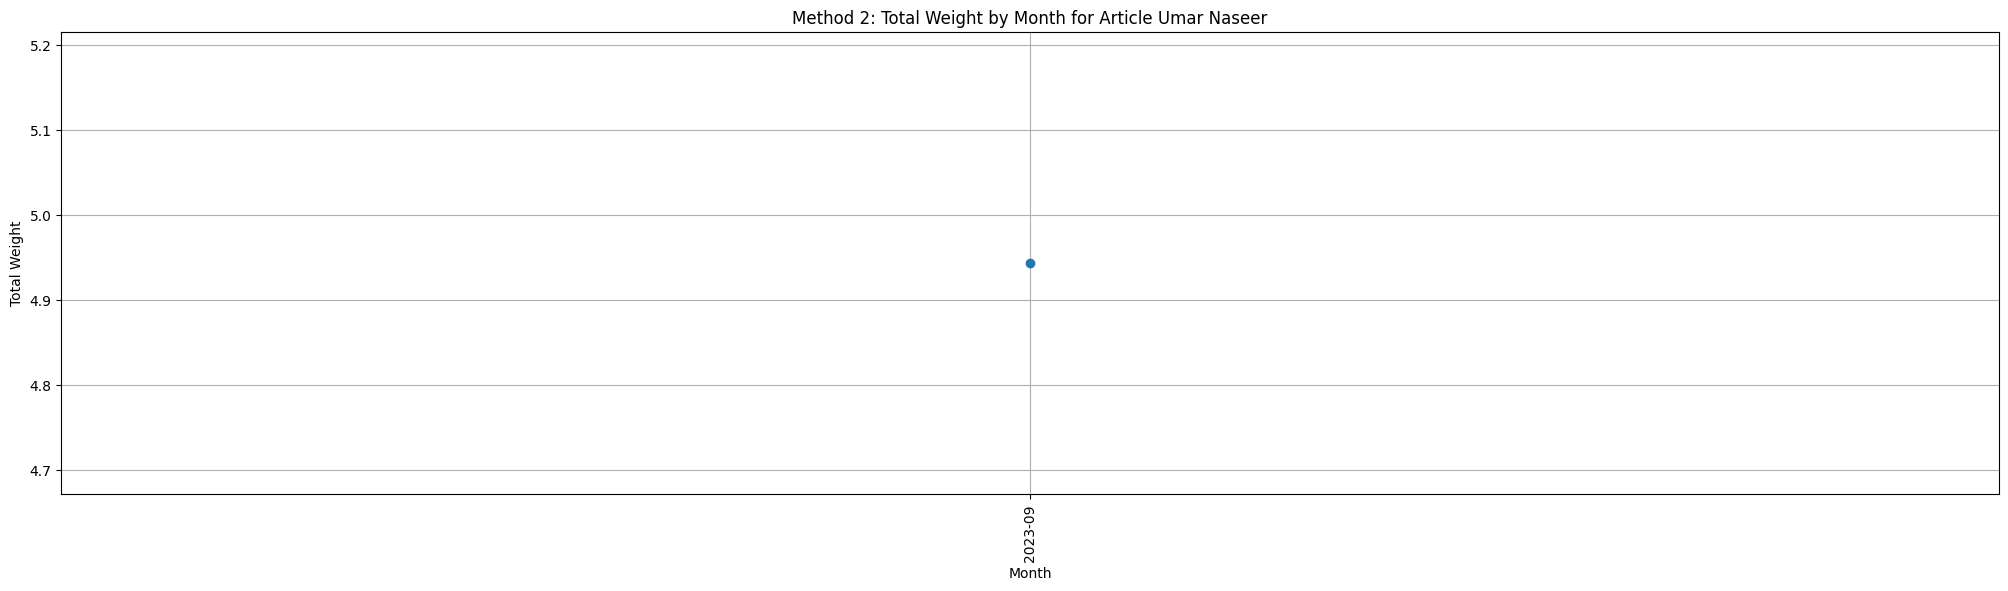

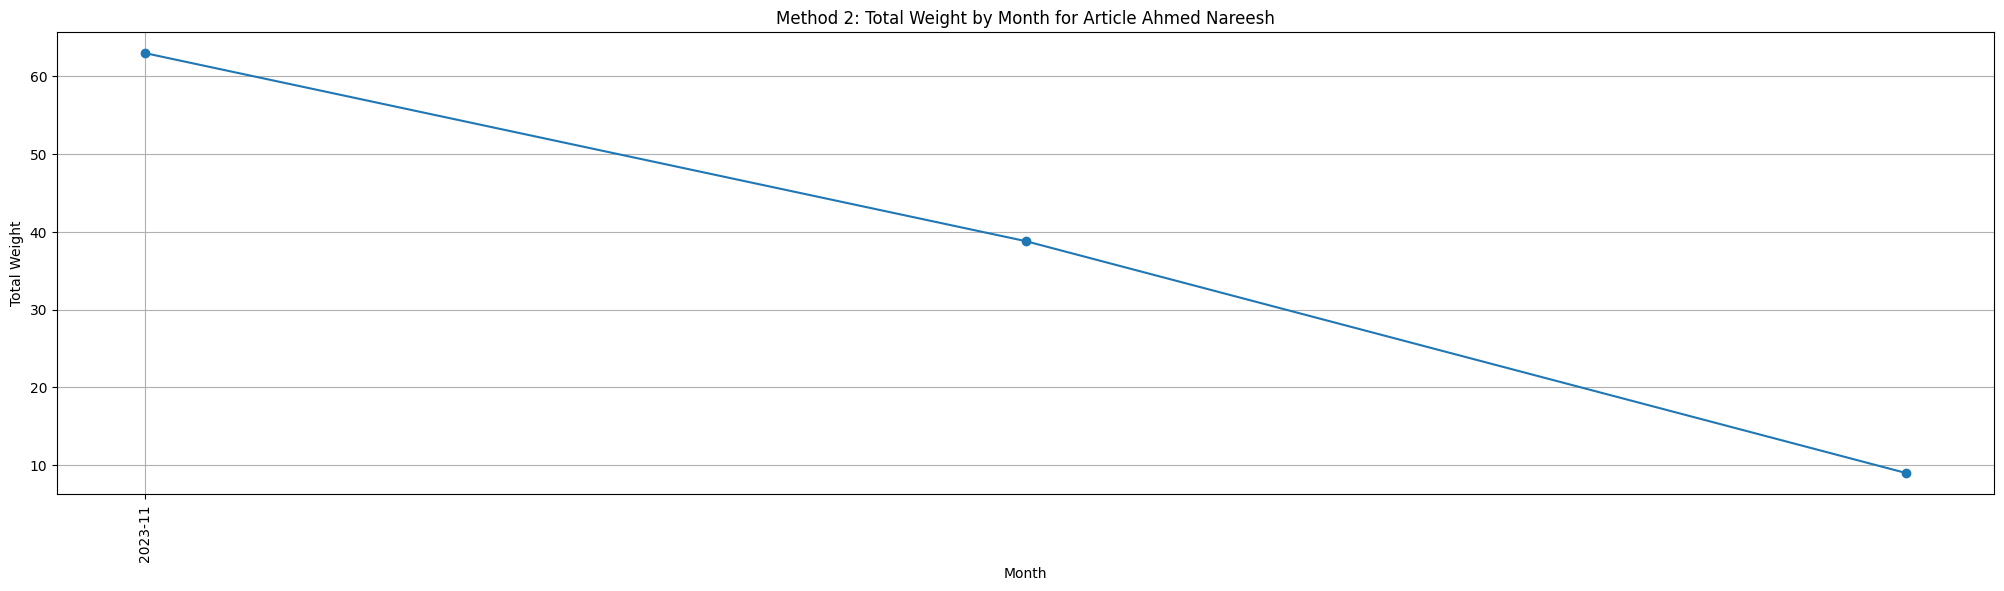

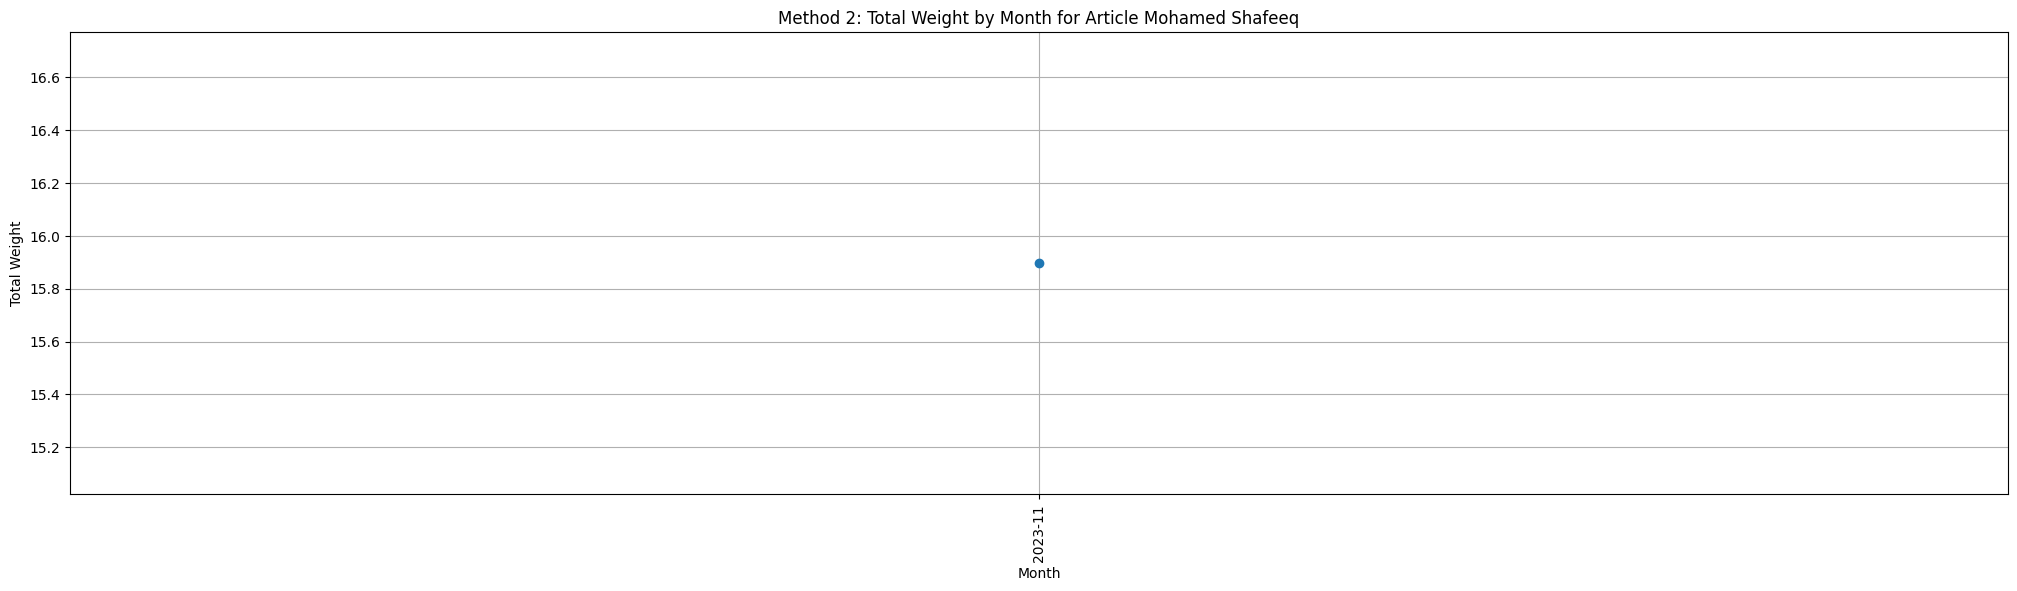

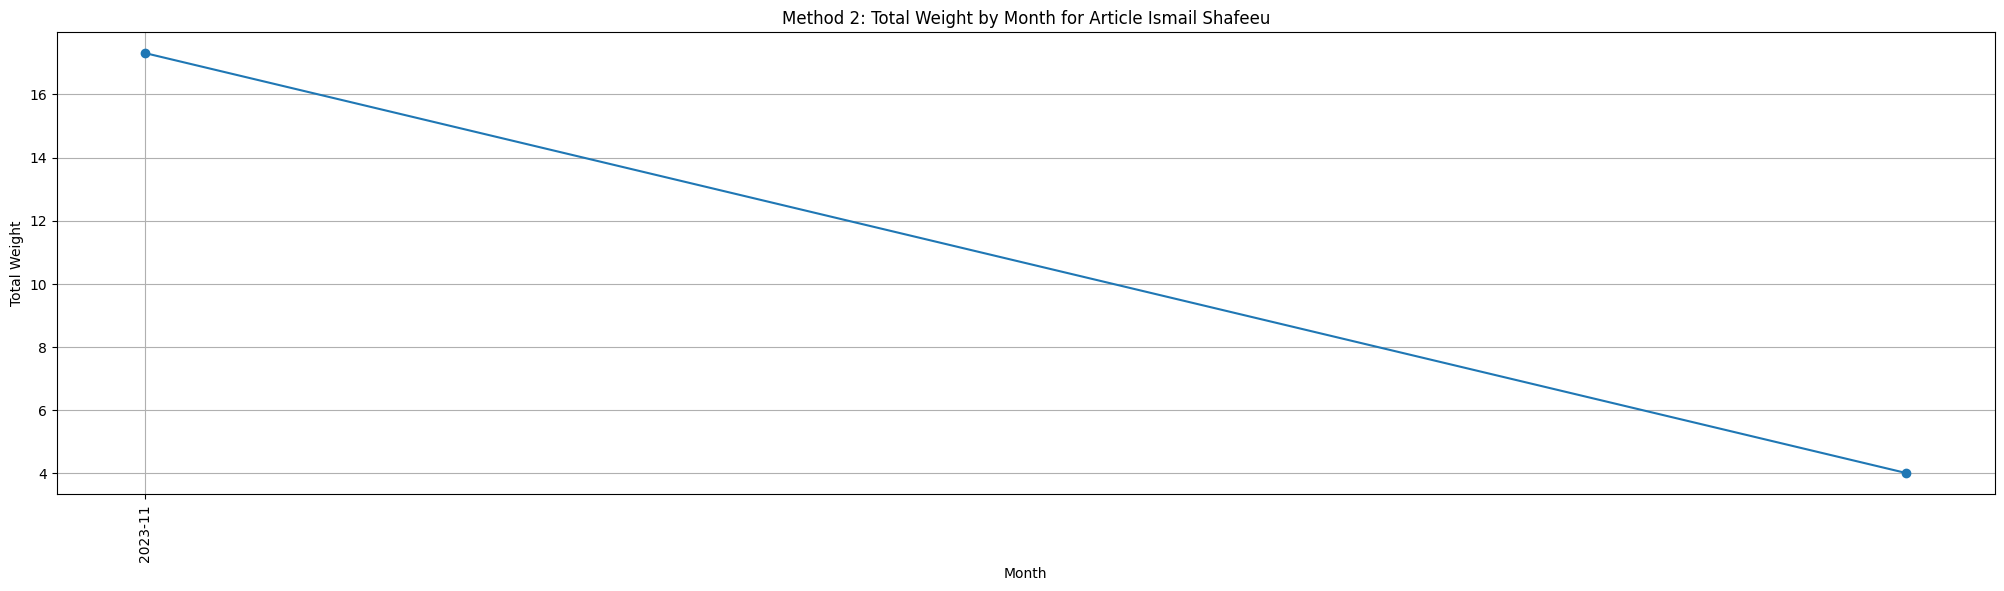

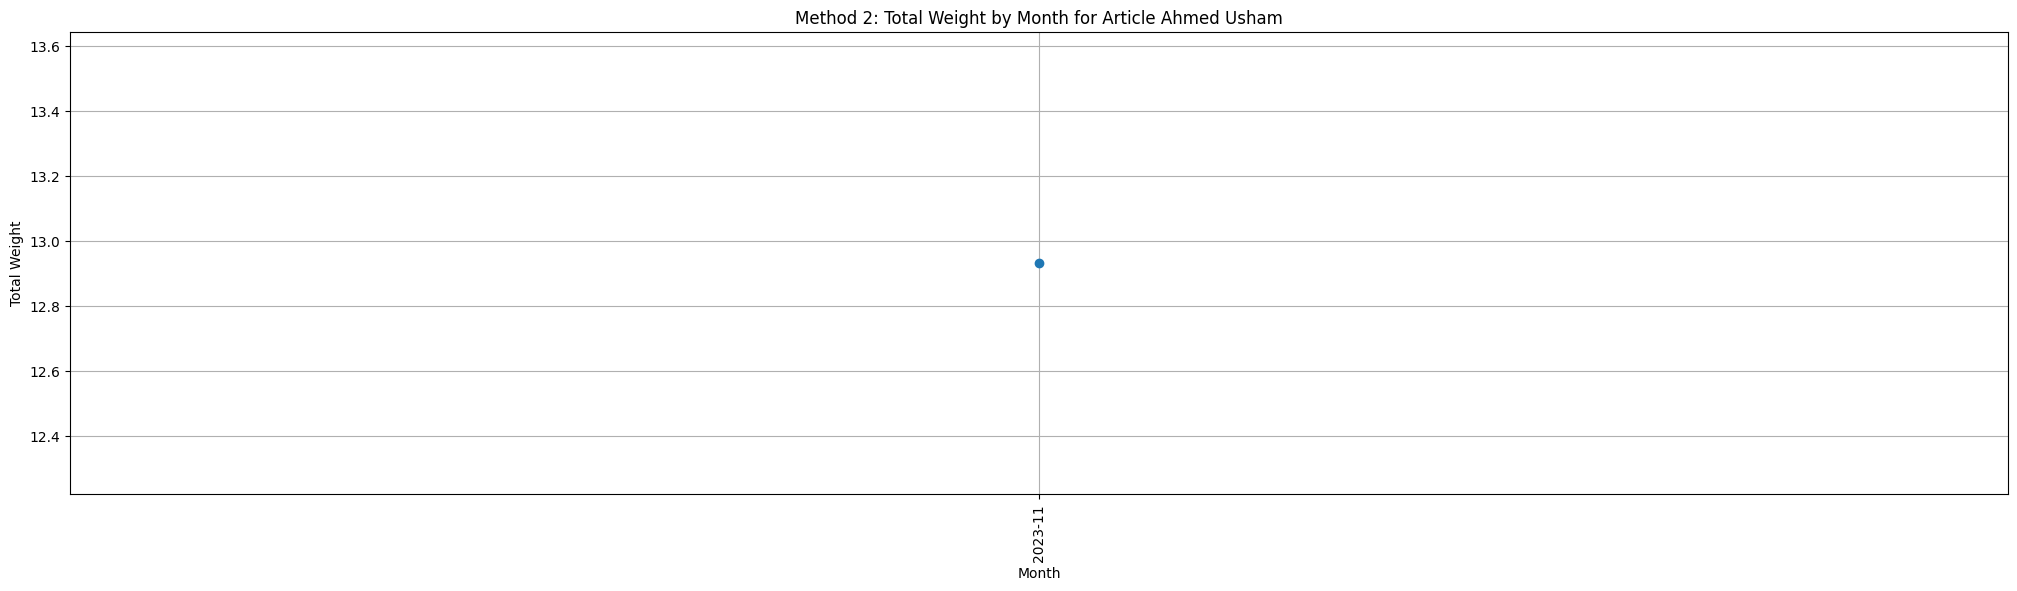

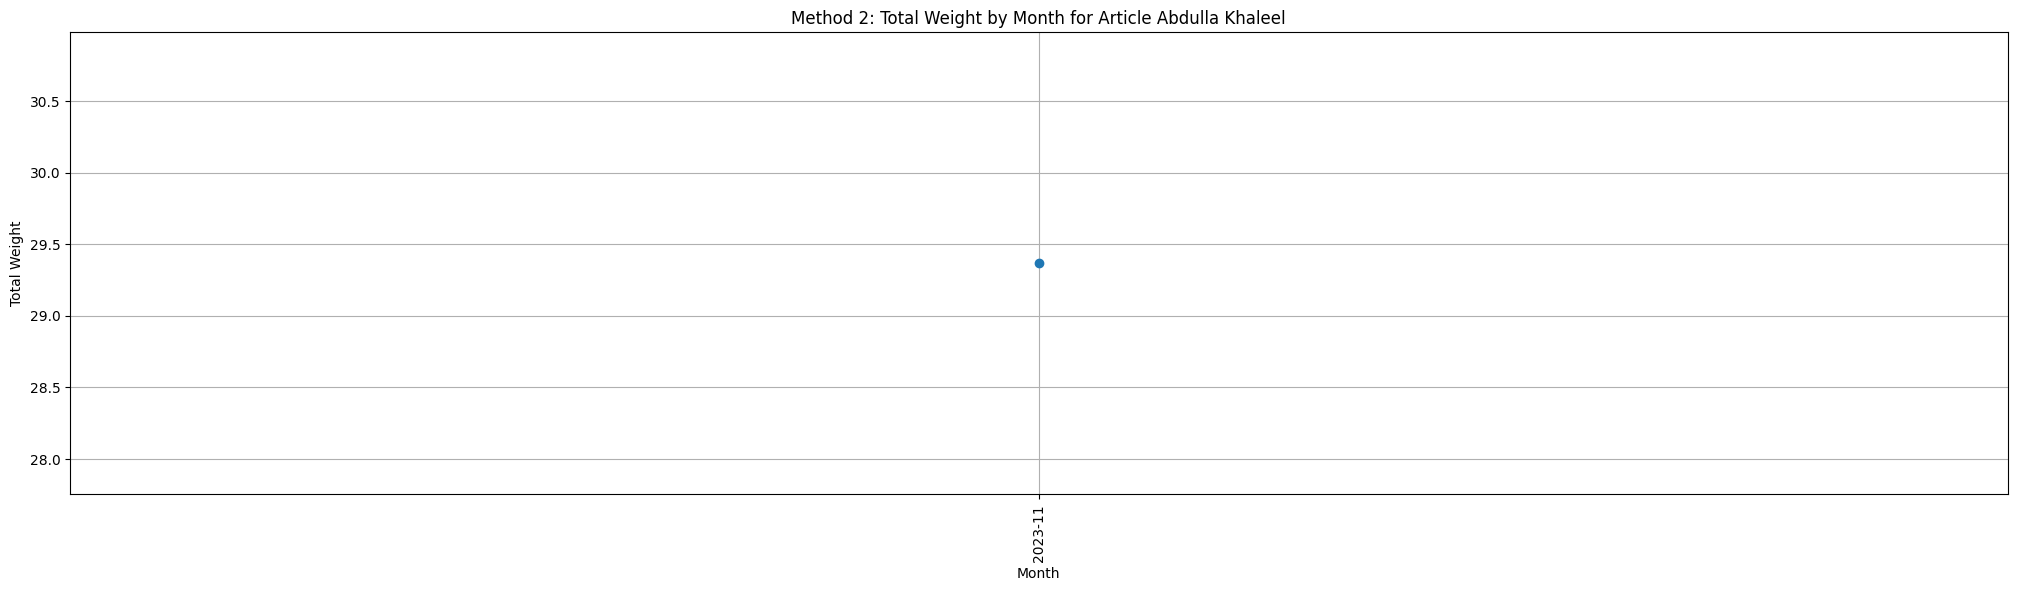

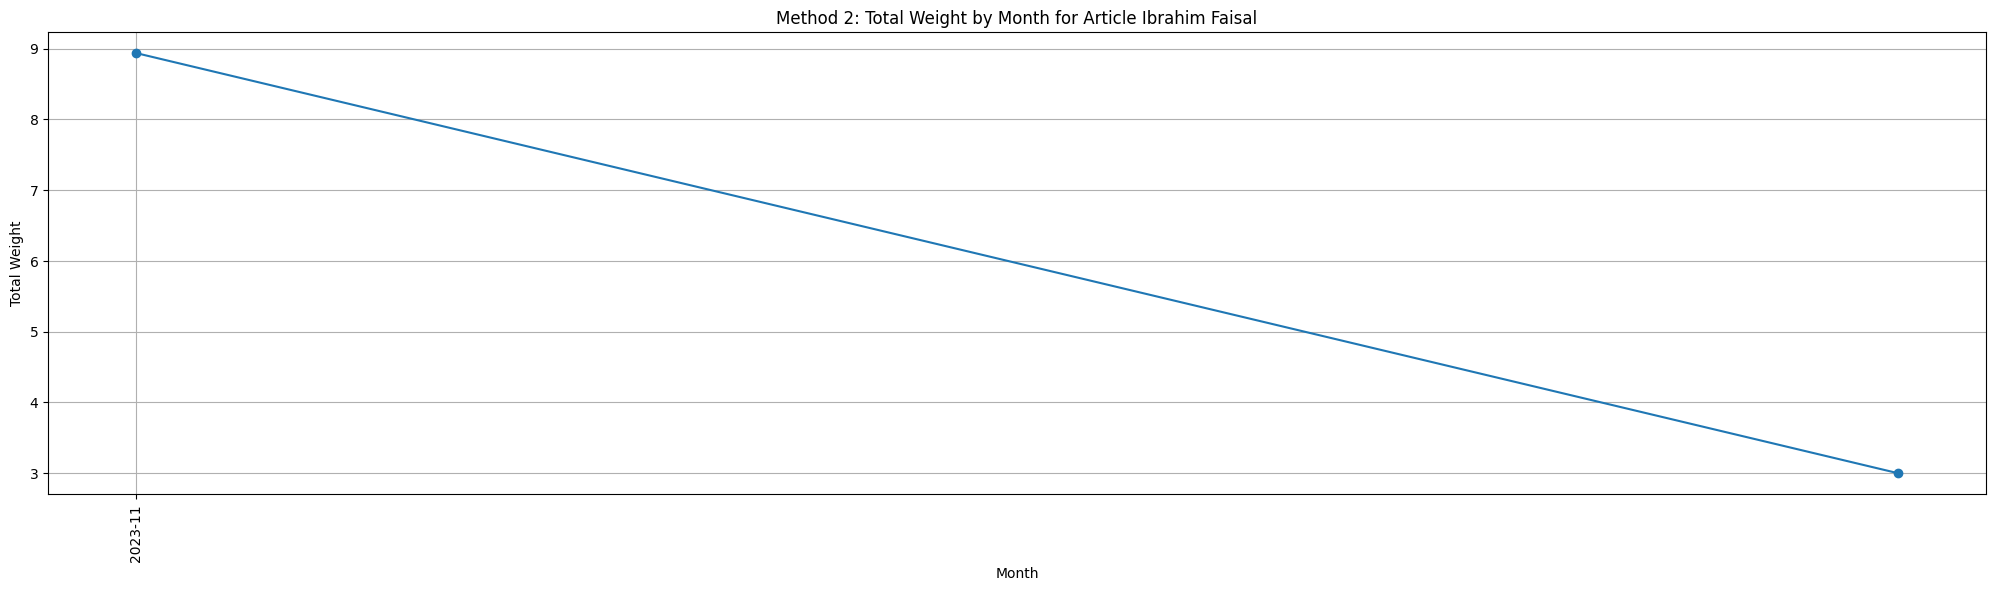

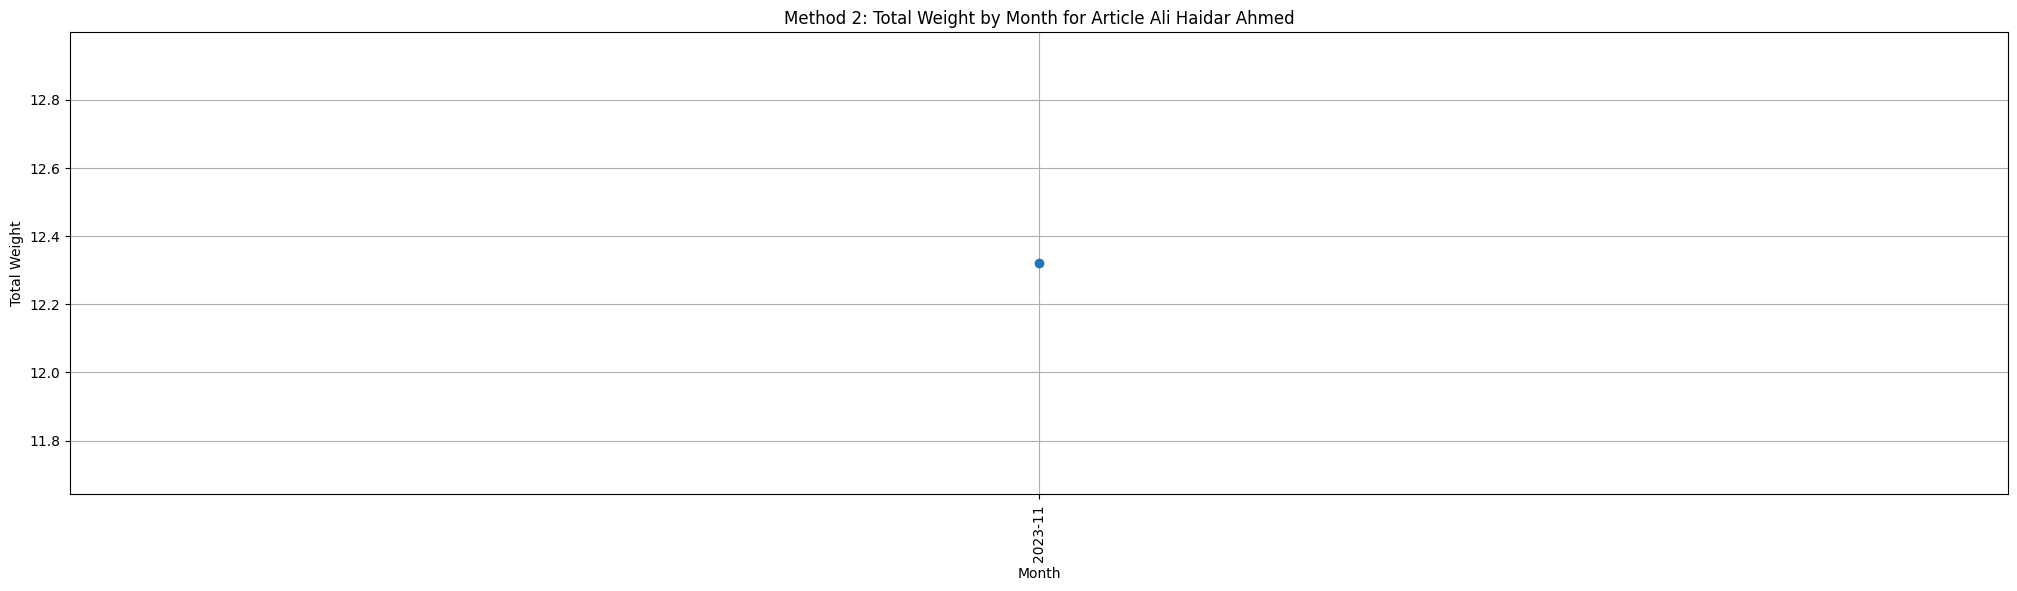

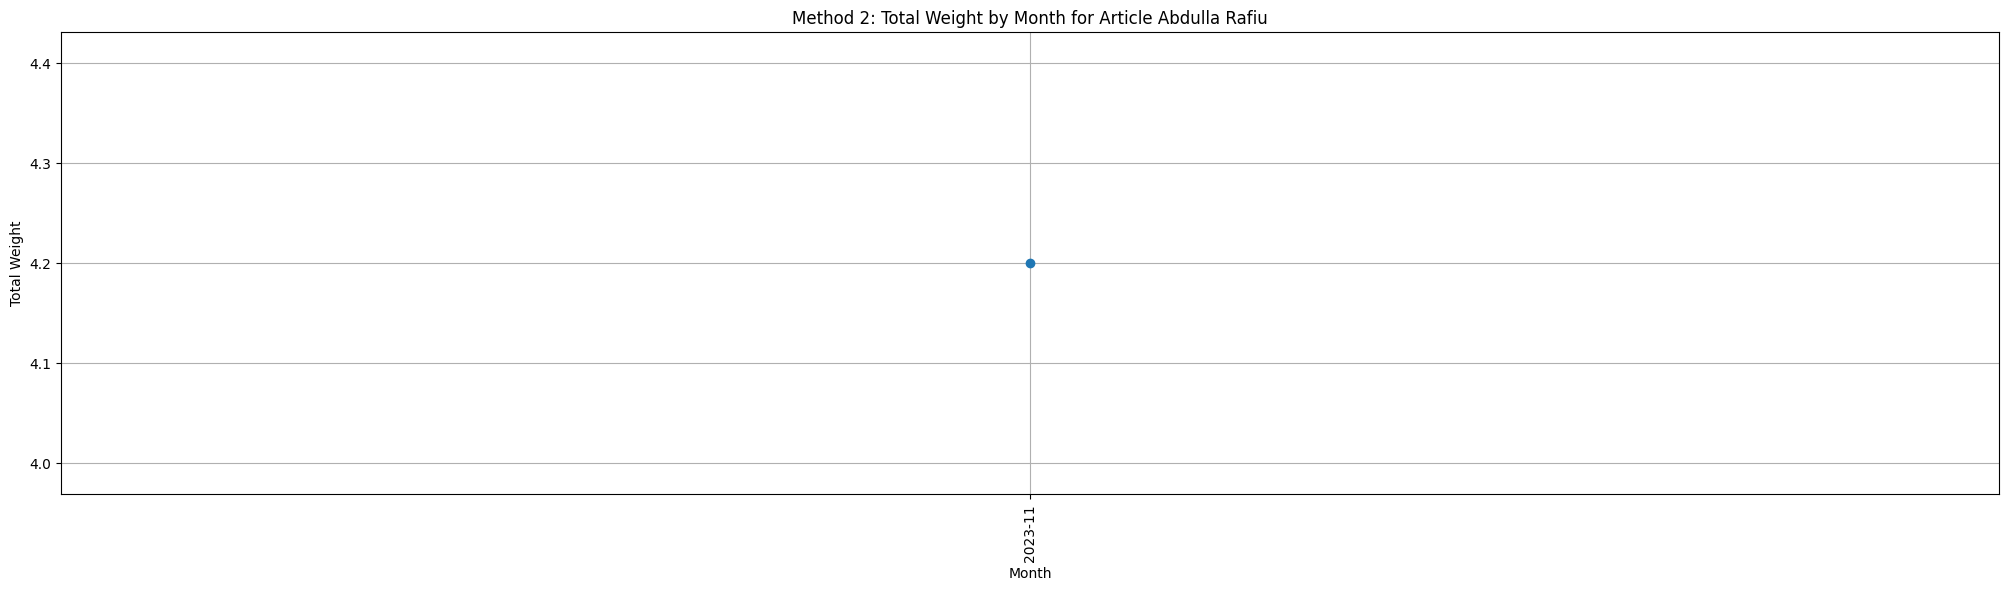

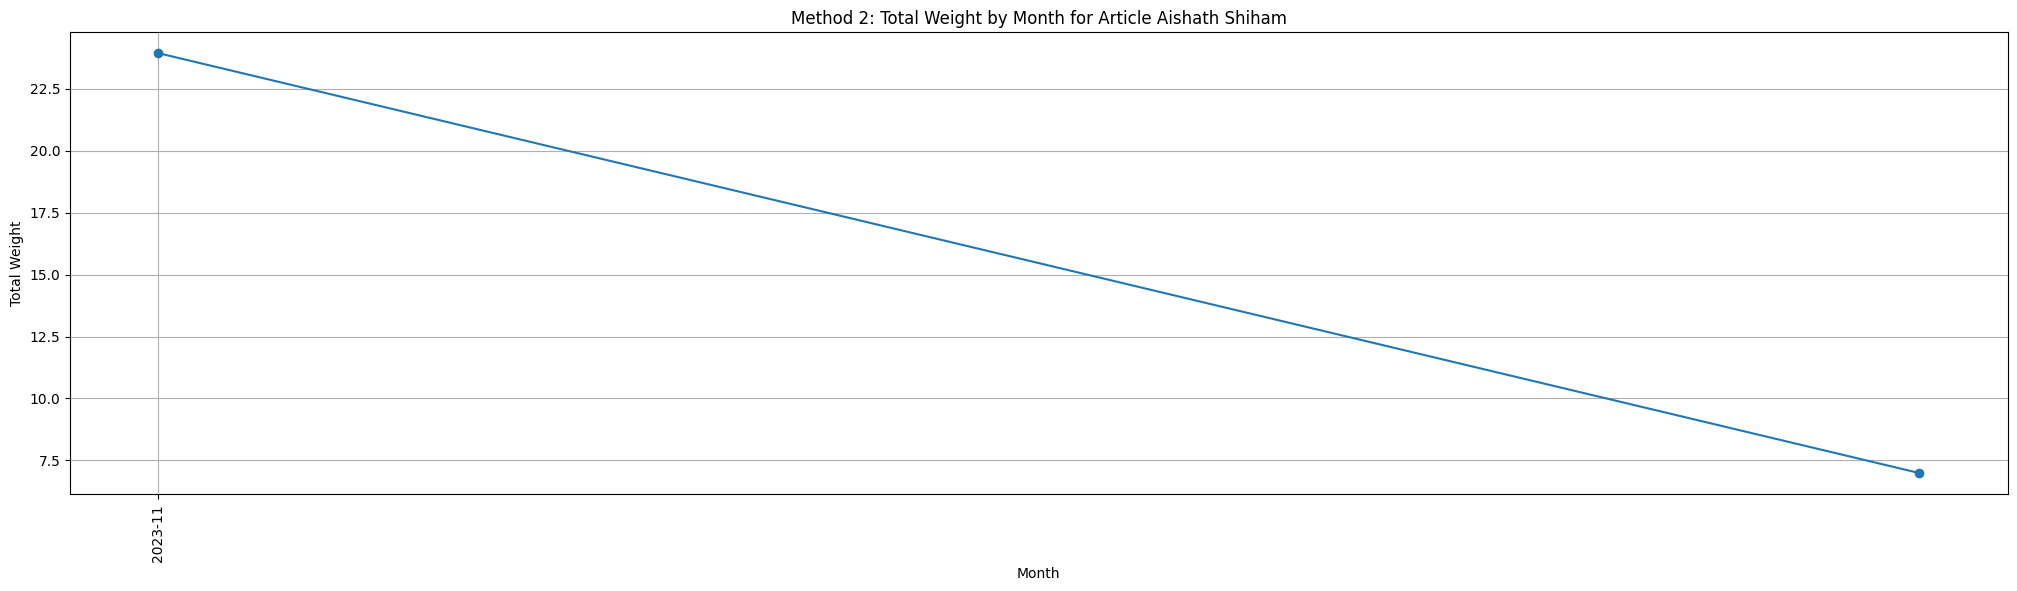

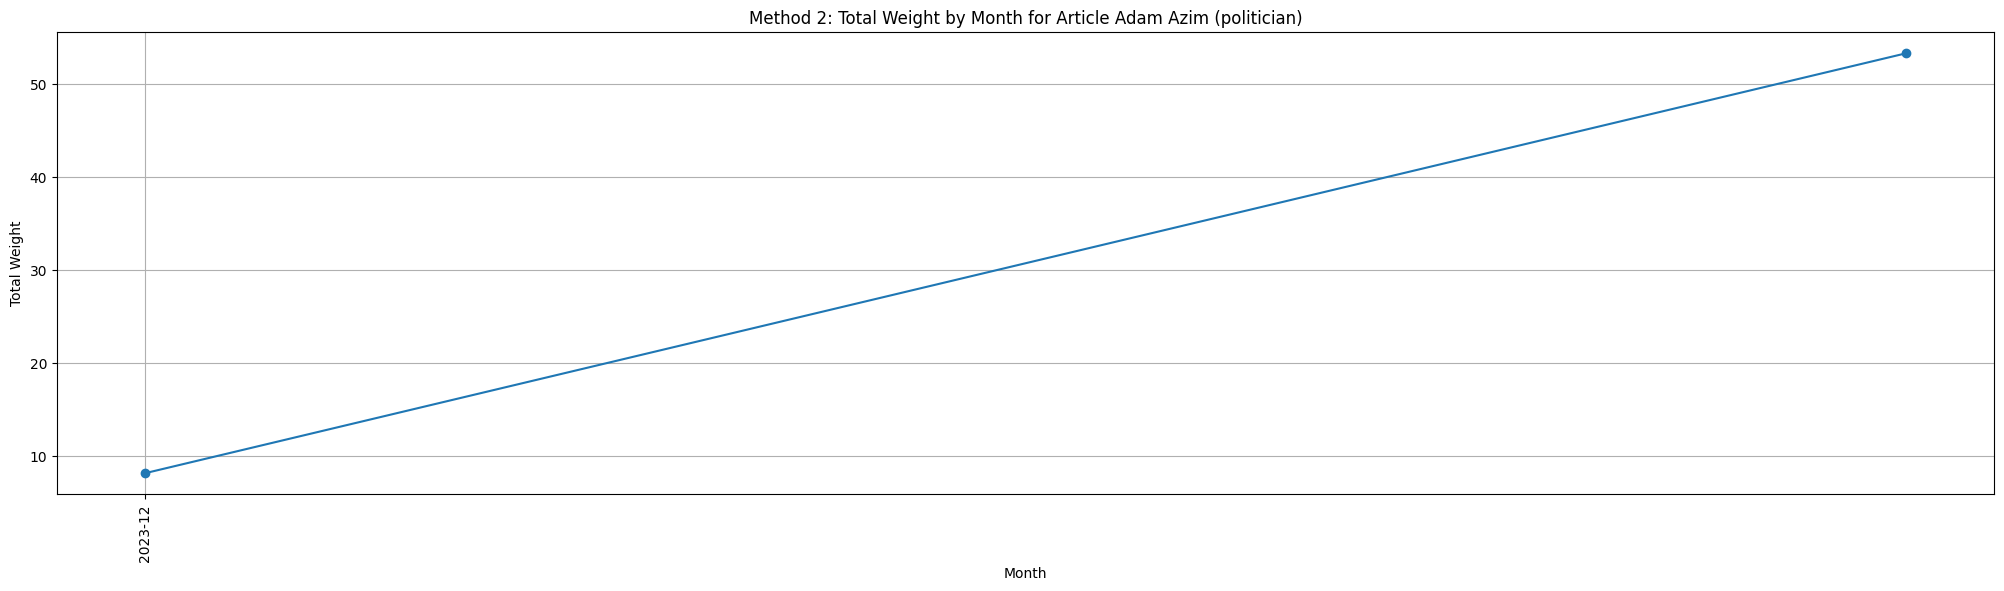

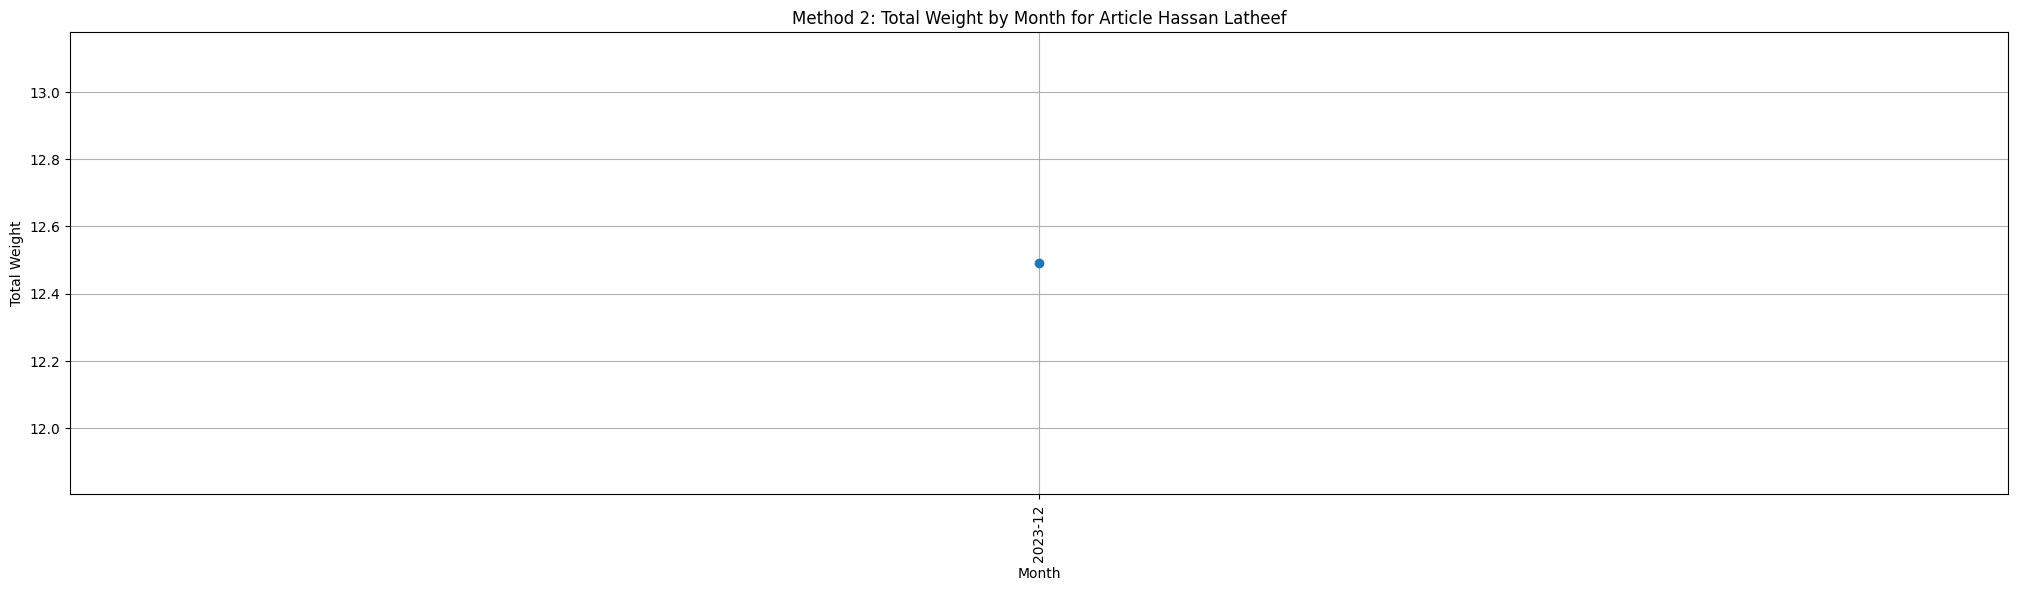

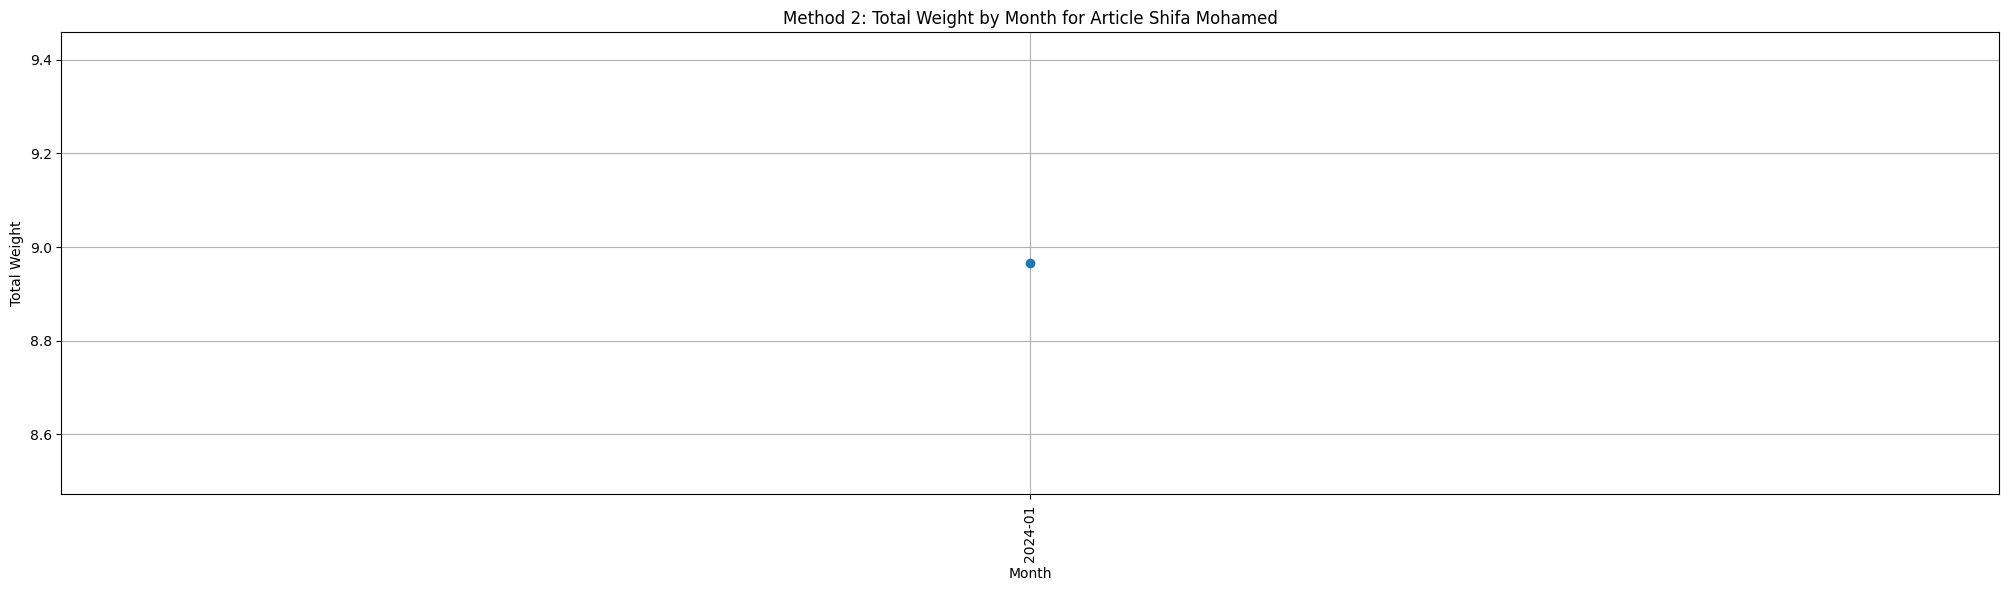

In [11]:
import matplotlib.pyplot as plt

# # Plot each article's total weight by month in a separate plot
# unique_articles = total_weights_by_month_df['Article Title'].unique()

for article_title in unique_articles:
    article_data = weights_df[weights_df['Article Title'] == article_title]
    plt.figure(figsize=(25, 6))
    plt.plot(article_data['Month'].astype(str), article_data['Weight'], marker='o', linestyle='-')
    plt.title(f'Method 2: Total Weight by Month for Article {article_title}')
    plt.xlabel('Month')
    plt.ylabel('Total Weight')
    plt.xticks(rotation=90)
    plt.xticks(ticks=article_data['Month'].astype(str)[::3]) 
    plt.grid(True)
    plt.show()

